In [89]:
# Introduction

# This notebook aims to predict ICU mortality using the GOSSIS dataset.
# The goal is to build a machine learning model that generalizes across diverse healthcare settings,
# providing clinicians with actionable insights to improve patient care globally.

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report

# Imbalanced data handling
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# Feature importance and interpretability
import shap

import warnings
warnings.filterwarnings('ignore')


In [90]:
# Load the dataset
data = pd.read_csv('dataset.csv')

# Display the first few rows
data.head()

encounter_id  patient_id  hospital_id   age    bmi  elective_surgery  \
0         66154       25312          118  68.0  22.73                 0   
1        114252       59342           81  77.0  27.42                 0   
2        119783       50777          118  25.0  31.95                 0   
3         79267       46918          118  81.0  22.64                 1   
4         92056       34377           33  19.0    NaN                 0   

   ethnicity gender  height           icu_admit_source  ...  \
0  Caucasian      M   180.3                      Floor  ...   
1  Caucasian      F   160.0                      Floor  ...   
2  Caucasian      F   172.7       Accident & Emergency  ...   
3  Caucasian      F   165.1  Operating Room / Recovery  ...   
4  Caucasian      M   188.0       Accident & Emergency  ...   

   diabetes_mellitus hepatic_failure immunosuppression  leukemia  lymphoma  \
0                1.0             0.0               0.0       0.0       0.0   
1                1.0             0.0               0.0       0.0       0.0   
2                0.0             0.0               0.0       0.0       0.0   
3                0.0             0.0               0.0       0.0       0.0   
4                0.0             0.0               0.0       0.0       0.0   

   solid_tumor_with_metastasis  apache_3j_bodysystem  apache_2_bodysystem  \
0                          0.0                Sepsis       Cardiovascular   
1                          0.0           Respiratory          Respiratory   
2                          0.0             Metabolic            Metabolic   
3                          0.0        Cardiovascular       Cardiovascular   
4                          0.0                Trauma               Trauma   

   Unnamed: 83  hospital_death  
0          NaN               0  
1          NaN               0  
2          NaN               0  
3          NaN               0  
4          NaN               0  

[5 rows x 85 columns]

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  object 
 12  icu_type                       91713 non-null 

### Dealing with missing values

Dataset Shape: (91713, 85)

Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null 

encounter_id  patient_id  hospital_id   age    bmi  elective_surgery  \
0         66154       25312          118  68.0  22.73                 0   
1        114252       59342           81  77.0  27.42                 0   
2        119783       50777          118  25.0  31.95                 0   
3         79267       46918          118  81.0  22.64                 1   
4         92056       34377           33  19.0    NaN                 0   

   ethnicity gender  height           icu_admit_source  ...  \
0  Caucasian      M   180.3                      Floor  ...   
1  Caucasian      F   160.0                      Floor  ...   
2  Caucasian      F   172.7       Accident & Emergency  ...   
3  Caucasian      F   165.1  Operating Room / Recovery  ...   
4  Caucasian      M   188.0       Accident & Emergency  ...   

   diabetes_mellitus hepatic_failure immunosuppression  leukemia  lymphoma  \
0                1.0             0.0               0.0       0.0       0.0   
1                1.0             0.0               0.0       0.0       0.0   
2                0.0             0.0               0.0       0.0       0.0   
3                0.0             0.0               0.0       0.0       0.0   
4                0.0             0.0               0.0       0.0       0.0   

   solid_tumor_with_metastasis  apache_3j_bodysystem  apache_2_bodysystem  \
0                          0.0                Sepsis       Cardiovascular   
1                          0.0           Respiratory          Respiratory   
2                          0.0             Metabolic            Metabolic   
3                          0.0        Cardiovascular       Cardiovascular   
4                          0.0                Trauma               Trauma   

   Unnamed: 83  hospital_death  
0          NaN               0  
1          NaN               0  
2          NaN               0  
3          NaN               0  
4          NaN               0  

[5 rows x 85 columns]


Missing Values in Each Column:
age                            4228
bmi                            3429
ethnicity                      1395
gender                           25
height                         1334
                               ... 
leukemia                        715
lymphoma                        715
solid_tumor_with_metastasis     715
apache_3j_bodysystem           1662
apache_2_bodysystem            1662
Length: 74, dtype: int64


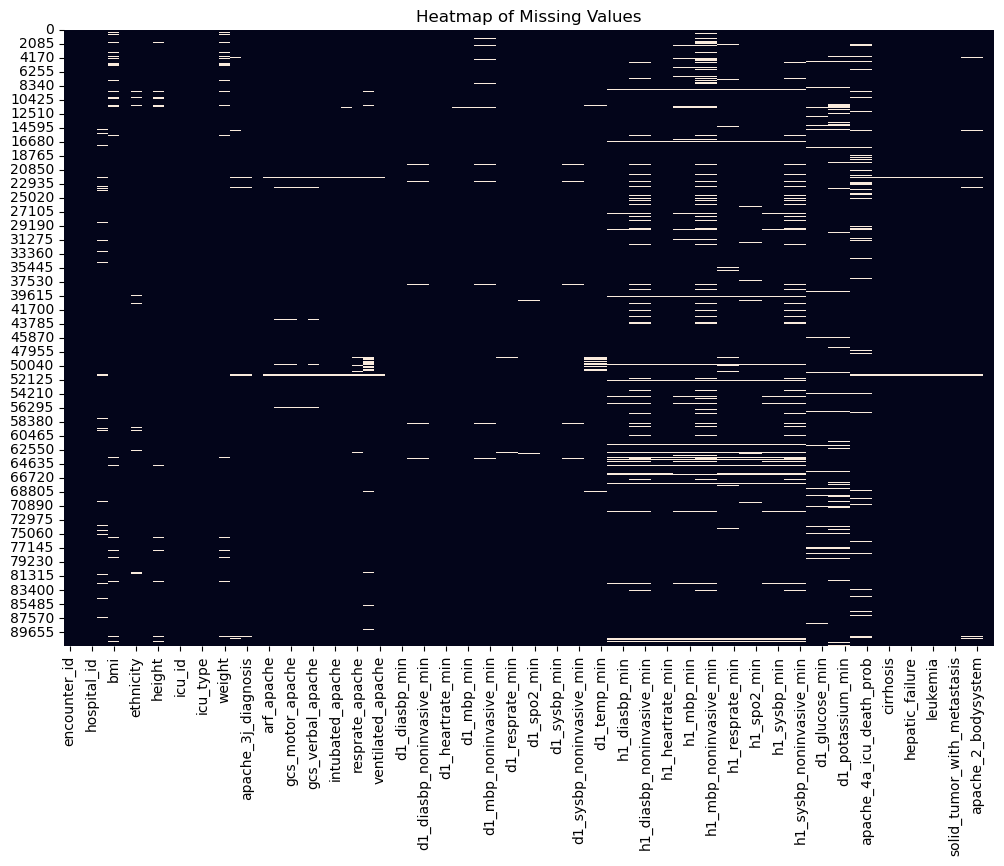

Percentage of Missing Values in Columns:
d1_potassium_min            10.451081
d1_potassium_max            10.451081
h1_mbp_noninvasive_min       9.904812
h1_mbp_noninvasive_max       9.904812
apache_4a_icu_death_prob     8.665075
                              ...    
d1_sysbp_min                 0.173367
d1_heartrate_max             0.158102
d1_heartrate_min             0.158102
icu_admit_source             0.122120
gender                       0.027259
Length: 74, dtype: float64


In [92]:
# Display basic information about the dataset
print("Dataset Shape:", data.shape)
print("\nData Types and Non-Null Counts:")
print(data.info())

# Display the first few rows
display(data.head())

data.drop(columns=['Unnamed: 83'], inplace=True)

# Check for missing values
print("\nMissing Values in Each Column:")
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

# Visualize missing values using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.isnull(), cbar=False)
plt.title('Heatmap of Missing Values')
plt.show()

# Display the percentage of missing values
missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
print("Percentage of Missing Values in Columns:")
print(missing_percentage)

# since all columns besides unamed are below 11%, we think we can just impute




Descriptive Statistics for Numerical Columns:


encounter_id     patient_id   hospital_id           age           bmi  \
count   91713.000000   91713.000000  91713.000000  87485.000000  88284.000000   
mean    65606.079280   65537.131464    105.669262     62.309516     29.185818   
std     37795.088538   37811.252183     62.854406     16.775119      8.275142   
min         1.000000       1.000000      2.000000     16.000000     14.844926   
25%     32852.000000   32830.000000     47.000000     52.000000     23.641975   
50%     65665.000000   65413.000000    109.000000     65.000000     27.654655   
75%     98342.000000   98298.000000    161.000000     75.000000     32.930206   
max    131051.000000  131051.000000    204.000000     89.000000     67.814990   

       elective_surgery        height        icu_id  pre_icu_los_days  \
count      91713.000000  90379.000000  91713.000000      91713.000000   
mean           0.183736    169.641588    508.357692          0.835766   
std            0.387271     10.795378    228.989661          2.487756   
min            0.000000    137.200000     82.000000        -24.947222   
25%            0.000000    162.500000    369.000000          0.035417   
50%            0.000000    170.100000    504.000000          0.138889   
75%            0.000000    177.800000    679.000000          0.409028   
max            1.000000    195.590000    927.000000        159.090972   

             weight  ...  apache_4a_icu_death_prob          aids  \
count  88993.000000  ...              83766.000000  90998.000000   
mean      84.028340  ...                  0.043955      0.000857   
std       25.011497  ...                  0.217341      0.029265   
min       38.600000  ...                 -1.000000      0.000000   
25%       66.800000  ...                  0.010000      0.000000   
50%       80.300000  ...                  0.020000      0.000000   
75%       97.100000  ...                  0.060000      0.000000   
max      186.000000  ...                  0.970000      1.000000   

          cirrhosis  diabetes_mellitus  hepatic_failure  immunosuppression  \
count  90998.000000       90998.000000     90998.000000       90998.000000   
mean       0.015693           0.225192         0.012989           0.026165   
std        0.124284           0.417711         0.113229           0.159628   
min        0.000000           0.000000         0.000000           0.000000   
25%        0.000000           0.000000         0.000000           0.000000   
50%        0.000000           0.000000         0.000000           0.000000   
75%        0.000000           0.000000         0.000000           0.000000   
max        1.000000           1.000000         1.000000           1.000000   

           leukemia      lymphoma  solid_tumor_with_metastasis  hospital_death  
count  90998.000000  90998.000000                 90998.000000    91713.000000  
mean       0.007066      0.004132                     0.020638        0.086302  
std        0.083763      0.064148                     0.142169        0.280811  
min        0.000000      0.000000                     0.000000        0.000000  
25%        0.000000      0.000000                     0.000000        0.000000  
50%        0.000000      0.000000                     0.000000        0.000000  
75%        0.000000      0.000000                     0.000000        0.000000  
max        1.000000      1.000000                     1.000000        1.000000  

[8 rows x 77 columns]


Descriptive Statistics for Categorical Columns:


ethnicity gender      icu_admit_source icu_stay_type      icu_type  \
count       90318  91688                 91601         91713         91713   
unique          6      2                     5             3             8   
top     Caucasian      M  Accident & Emergency         admit  Med-Surg ICU   
freq        70684  49469                 54060         86183         50586   

       apache_3j_bodysystem apache_2_bodysystem  
count                 90051               90051  
unique                   11                  10  
top          Cardiovascular      Cardiovascular  
freq                  29999               38816


Numerical Features: ['encounter_id', 'patient_id', 'hospital_id', 'age', 'bmi', 'elective_surgery', 'height', 'icu_id', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'heart_rate_apache', 'intubated_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvas

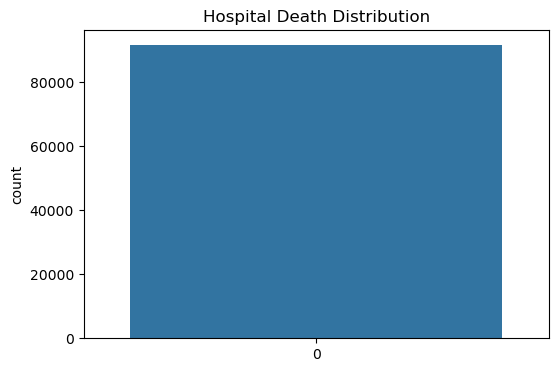

0    83798
1     7915
Name: hospital_death, dtype: int64

Percentage Distribution:
0    91.369817
1     8.630183
Name: hospital_death, dtype: float64


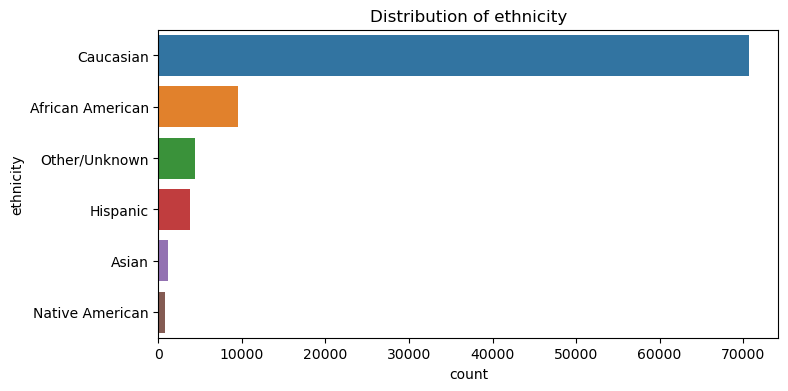

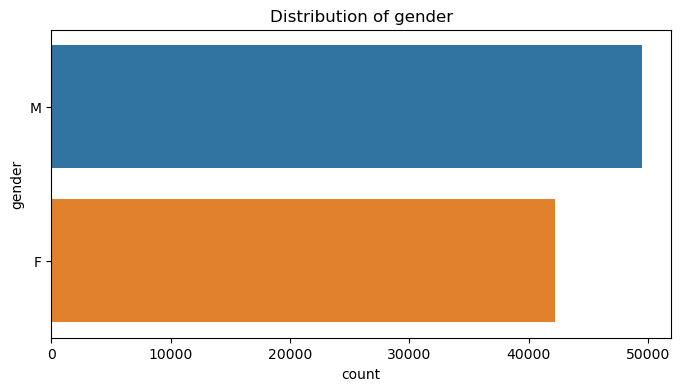

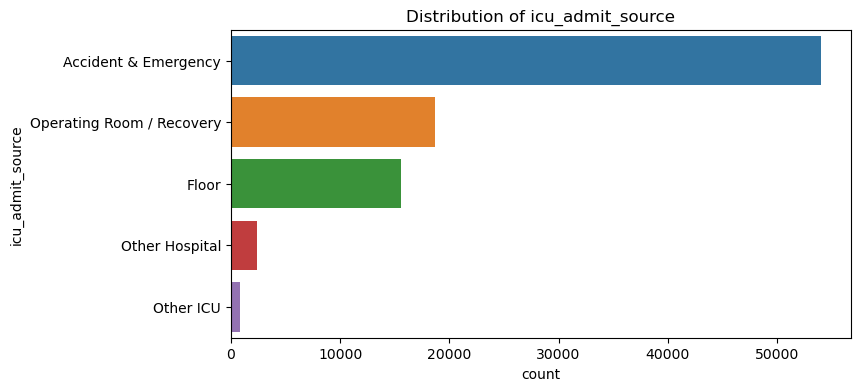

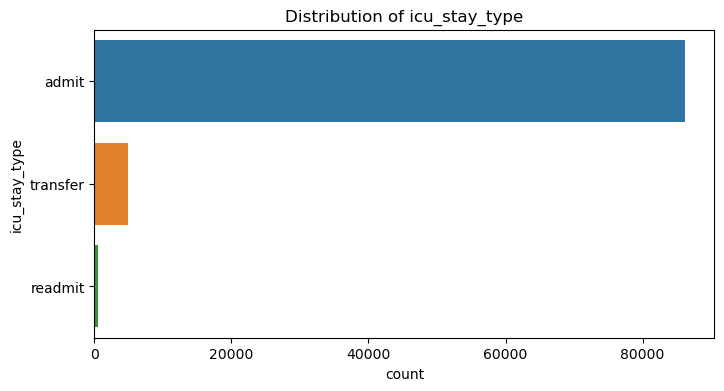

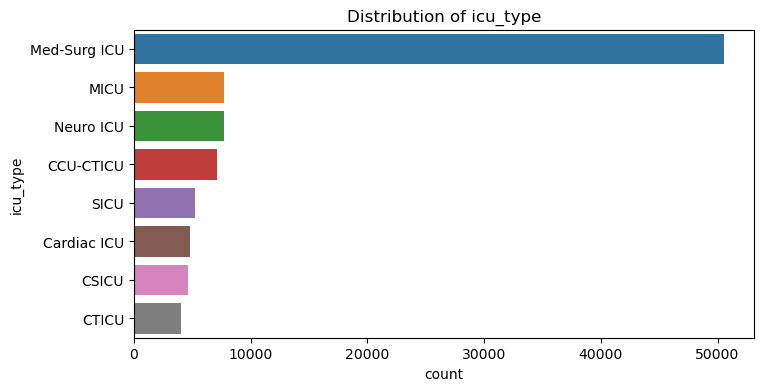

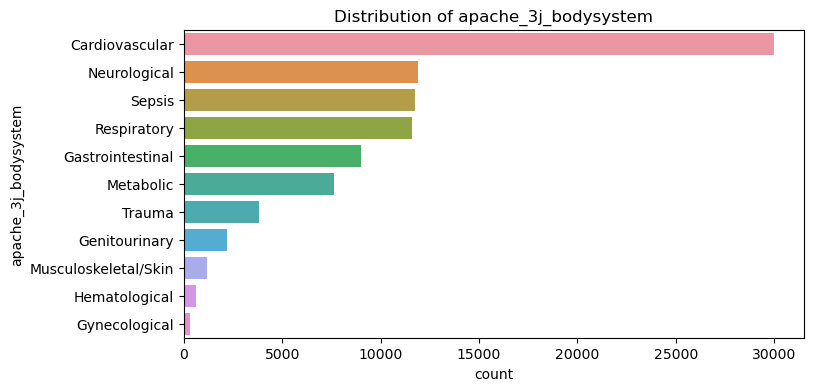

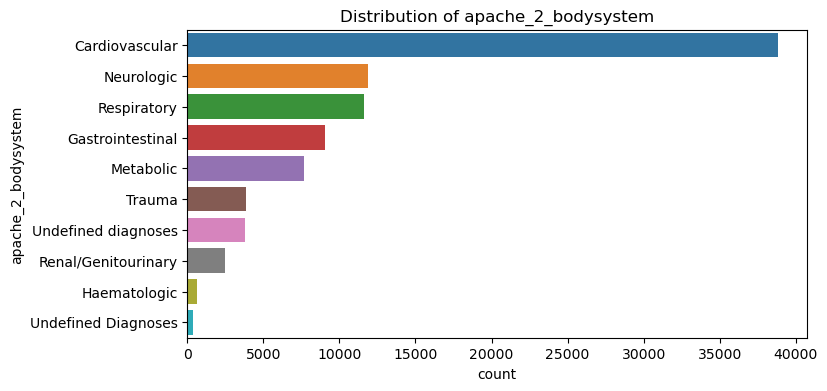

In [93]:



# Descriptive statistics for numerical columns
print("\nDescriptive Statistics for Numerical Columns:")
display(data.describe())

# Descriptive statistics for categorical columns
print("\nDescriptive Statistics for Categorical Columns:")
categorical_cols = data.select_dtypes(include=['object']).columns
display(data[categorical_cols].describe())

# List of numerical and categorical features
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

print("\nNumerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

# Target variable distribution
print("\nTarget Variable Distribution:")
plt.figure(figsize=(6, 4))
sns.countplot(data['hospital_death'])
plt.title('Hospital Death Distribution')
plt.show()

print(data['hospital_death'].value_counts())
print("\nPercentage Distribution:")
print(data['hospital_death'].value_counts(normalize=True) * 100)

# Analyze categorical features
for col in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=col, data=data, order=data[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.show()



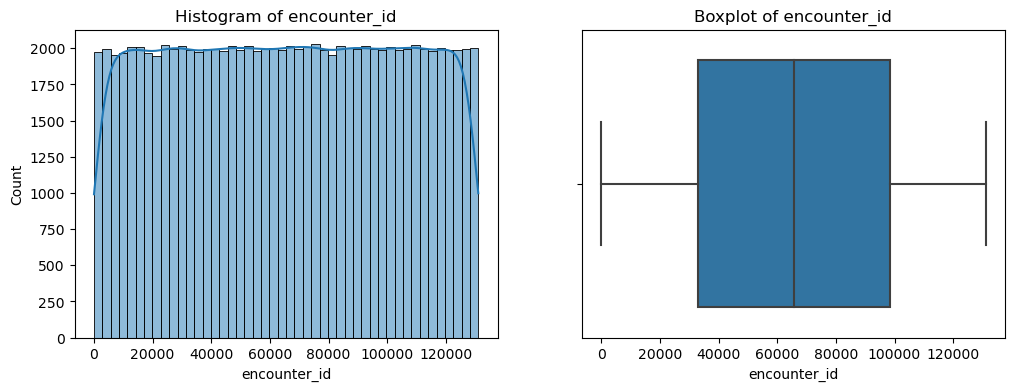

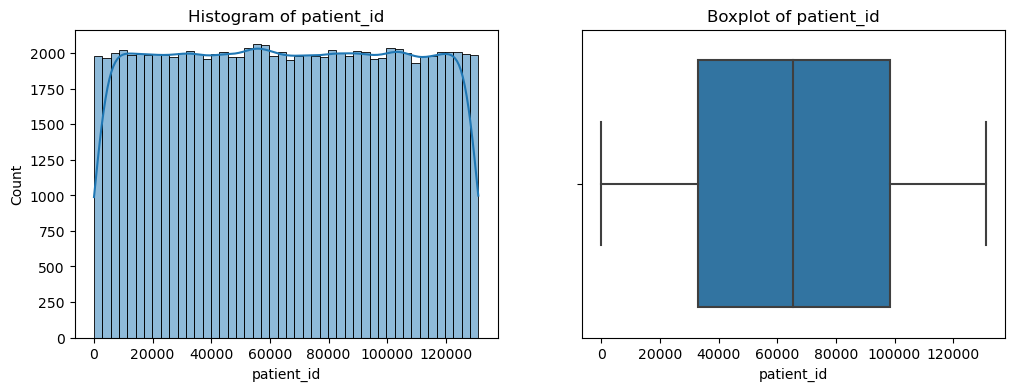

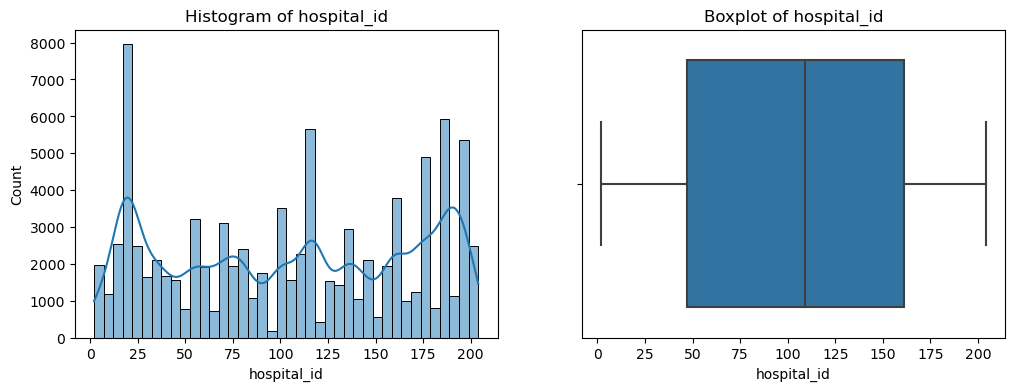

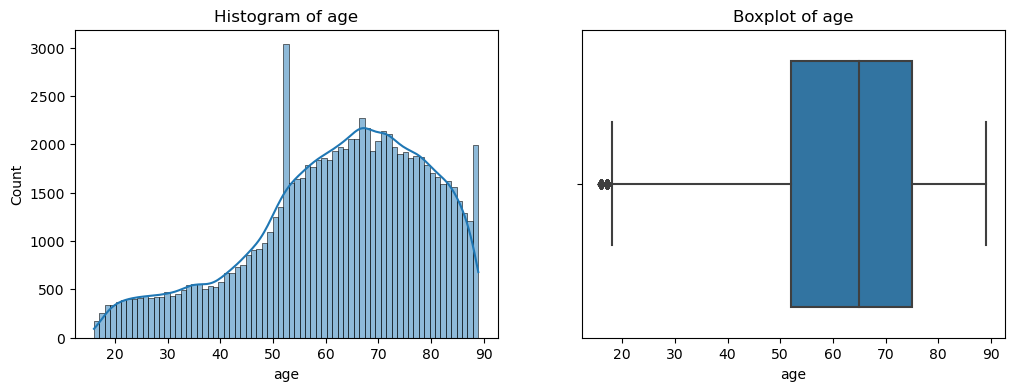

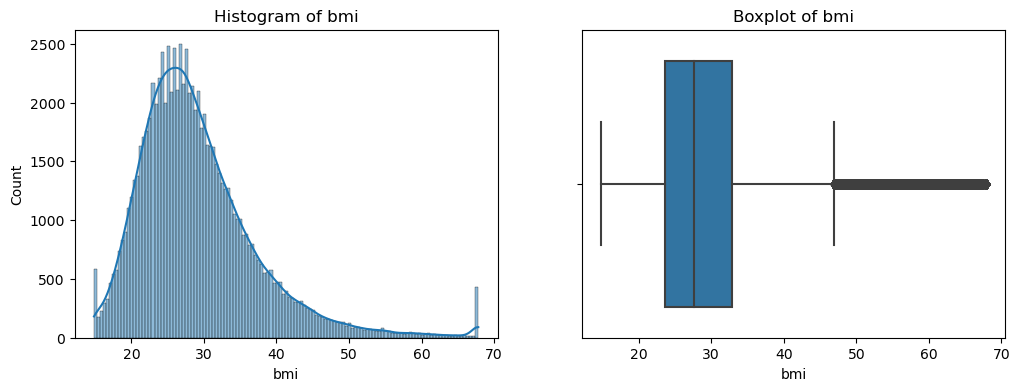

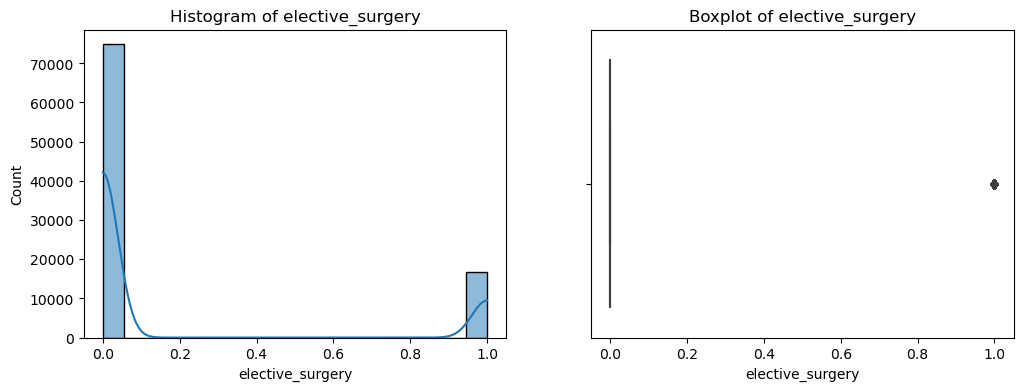

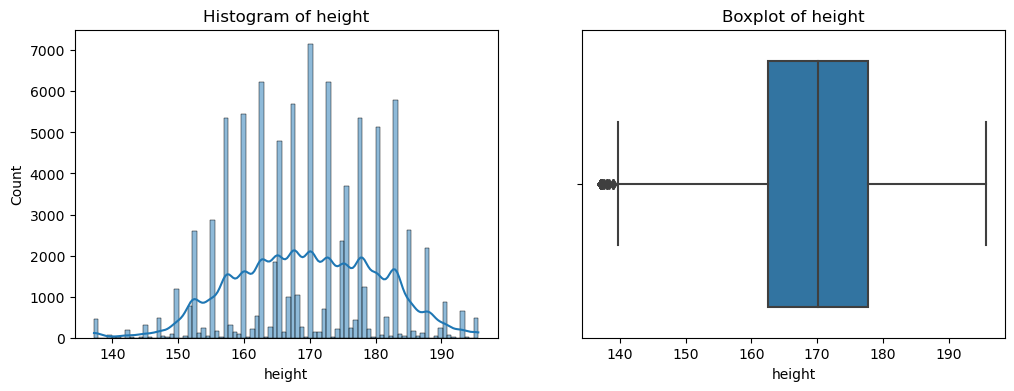

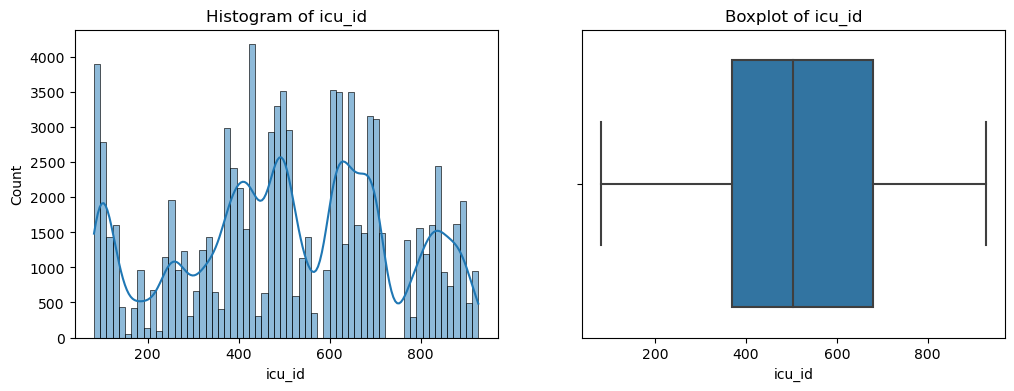

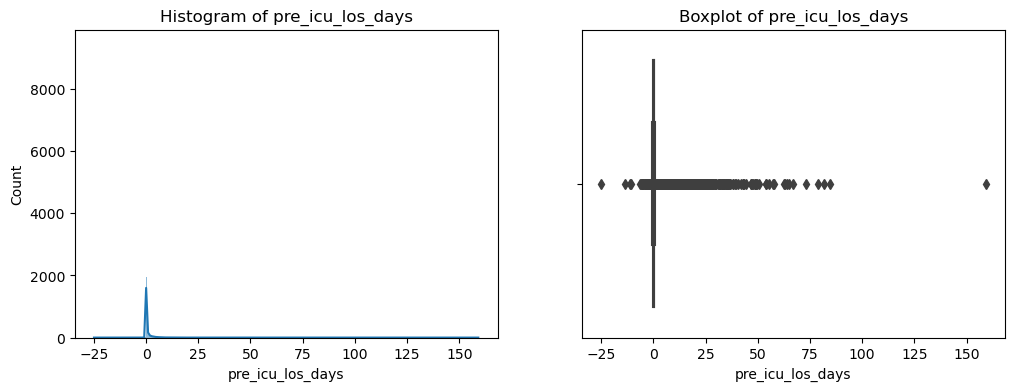

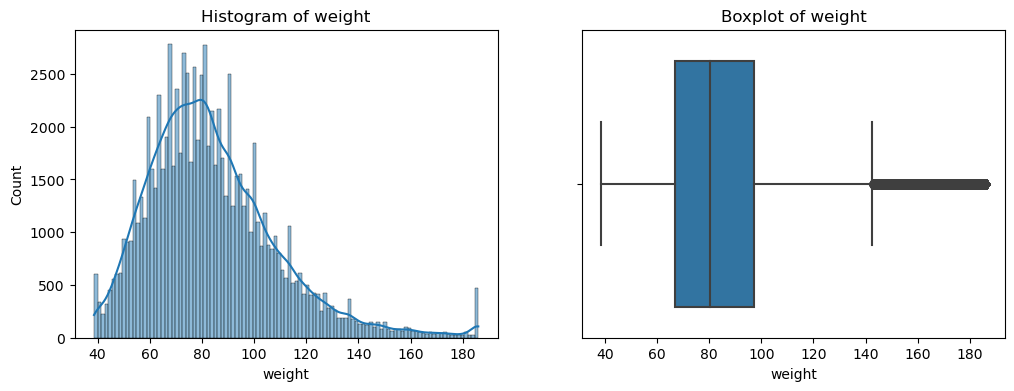

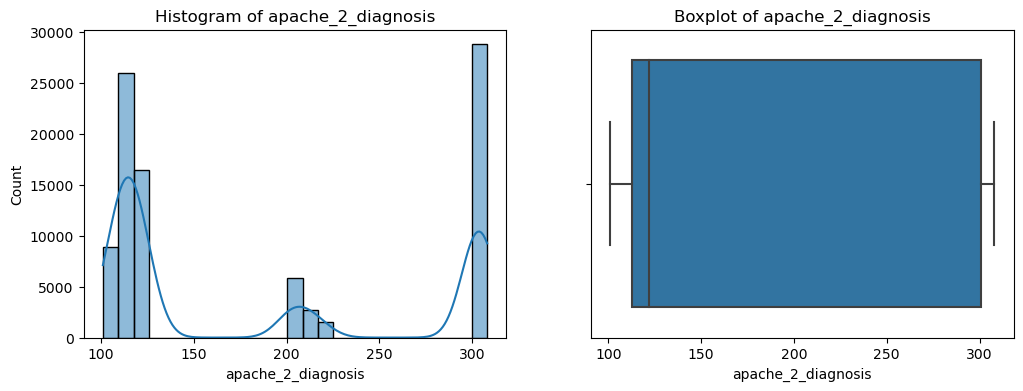

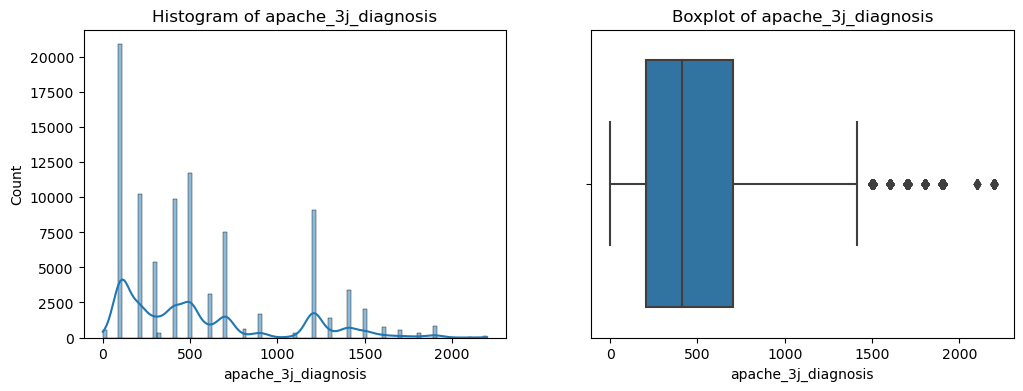

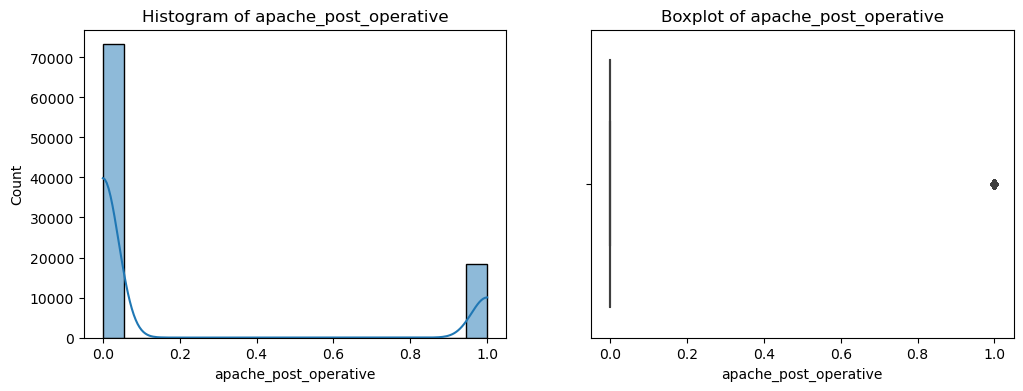

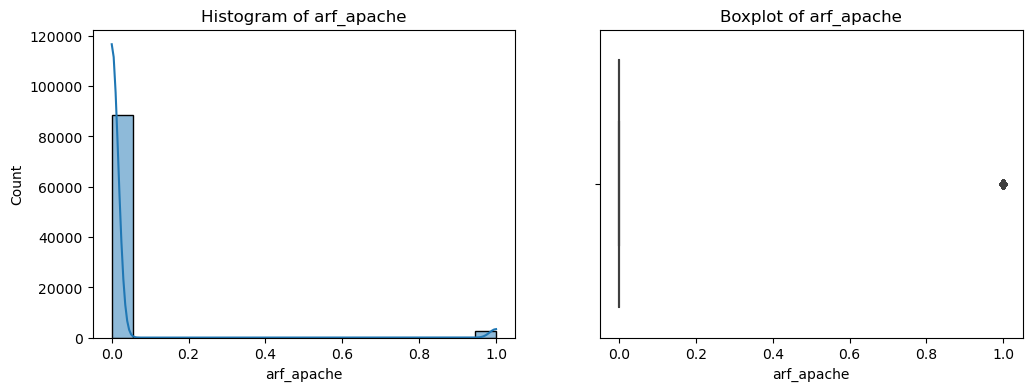

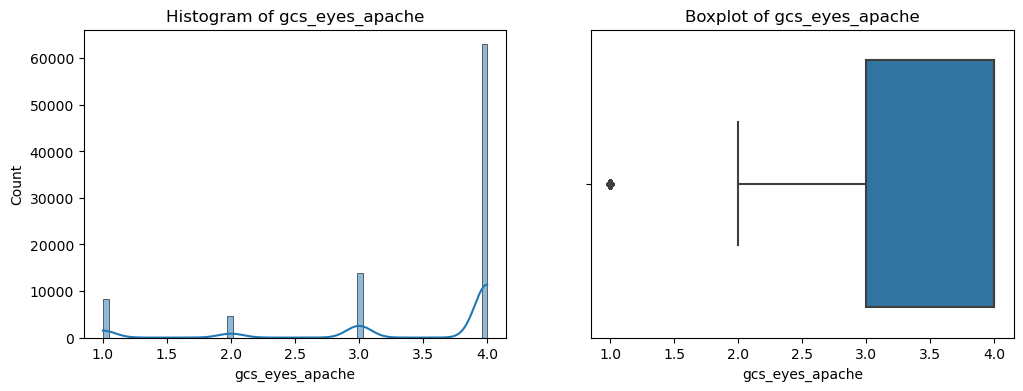

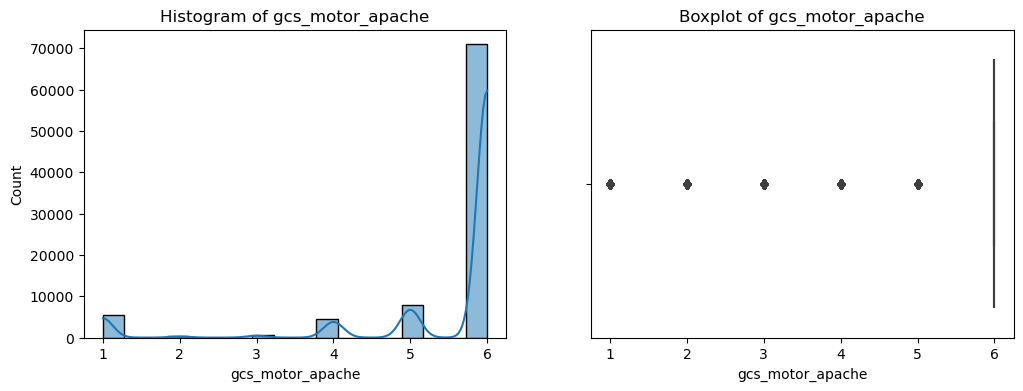

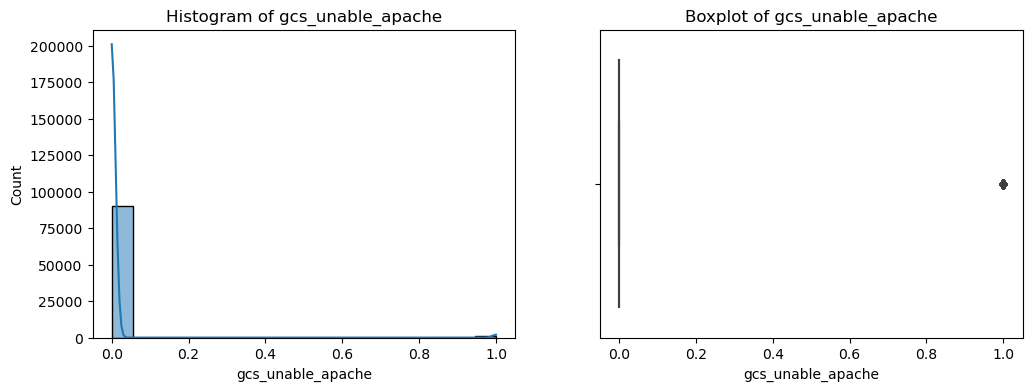

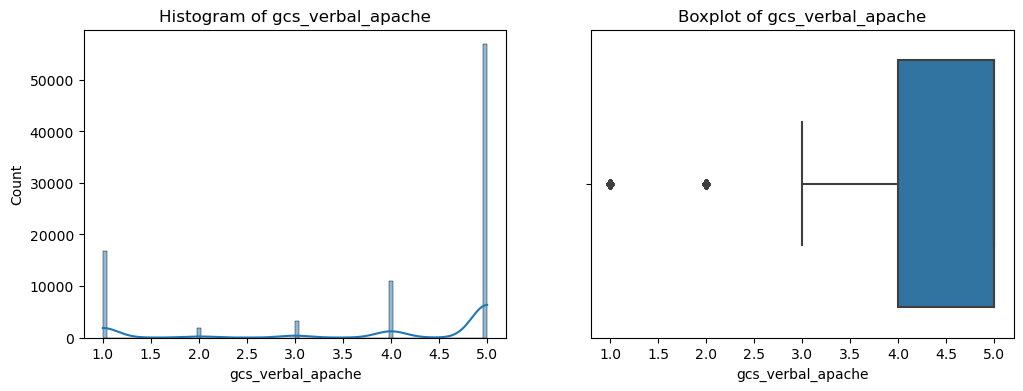

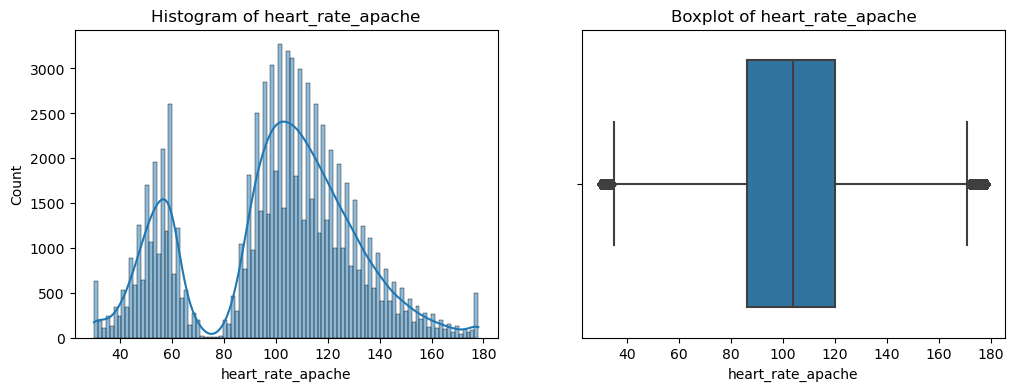

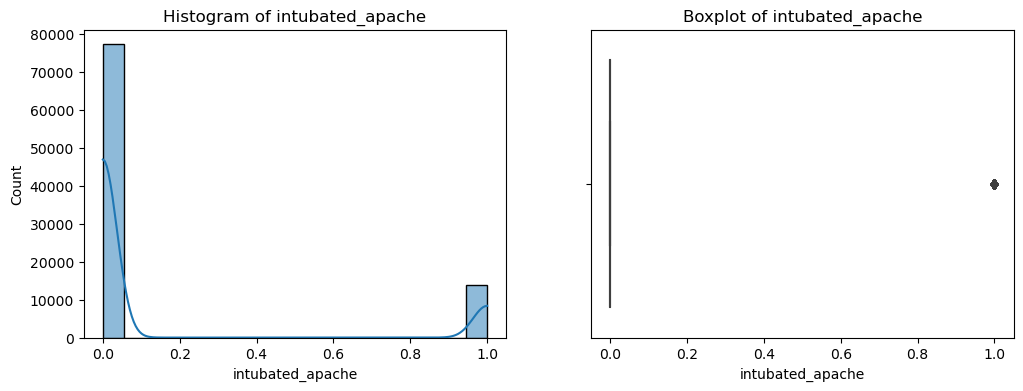

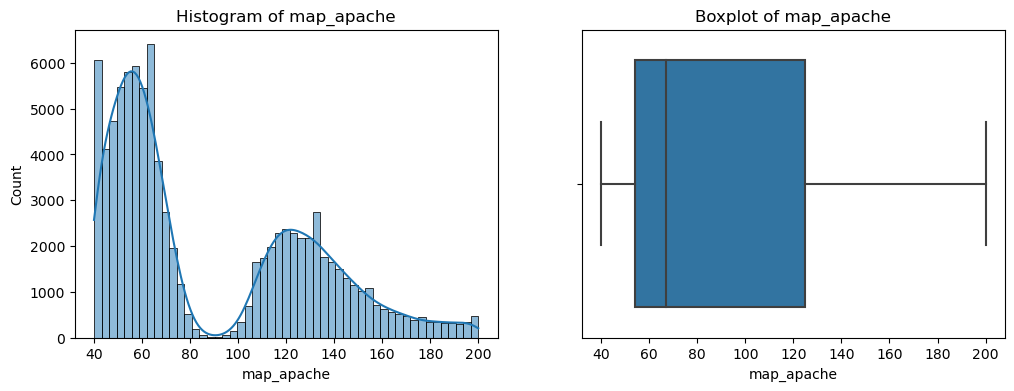

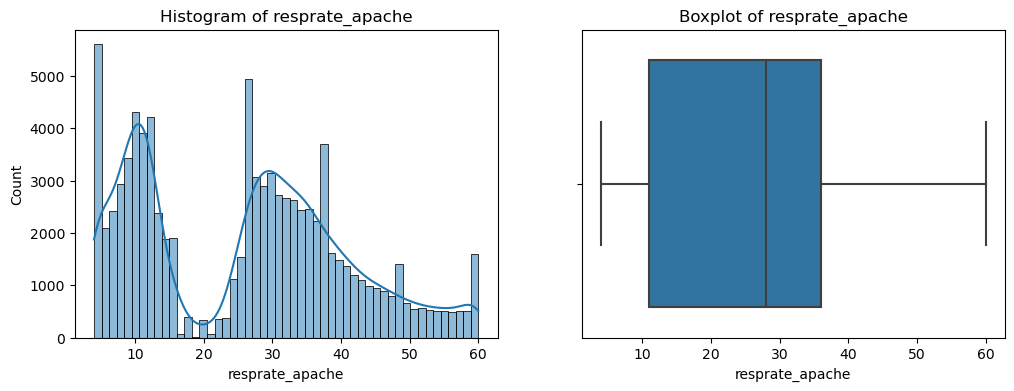

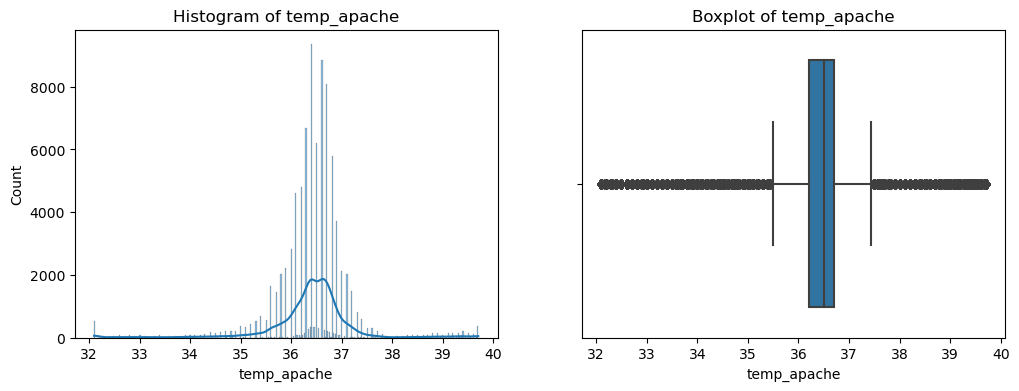

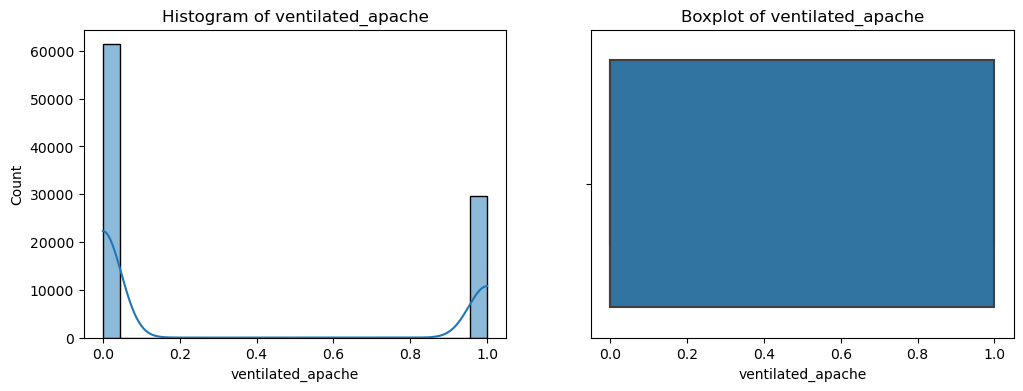

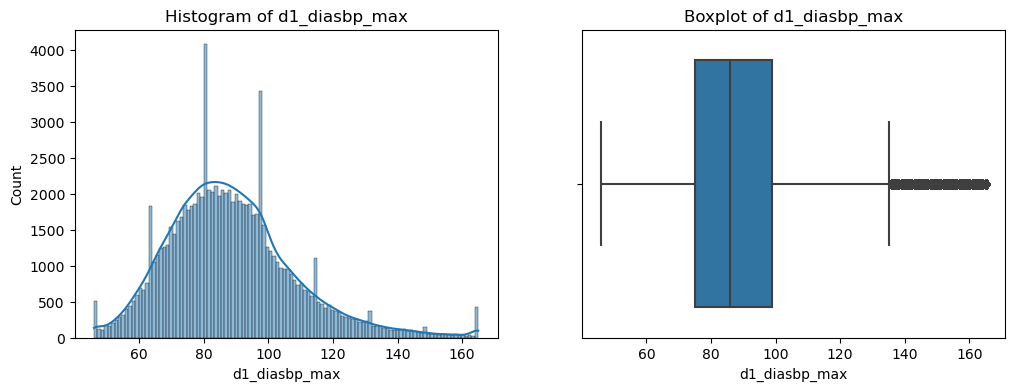

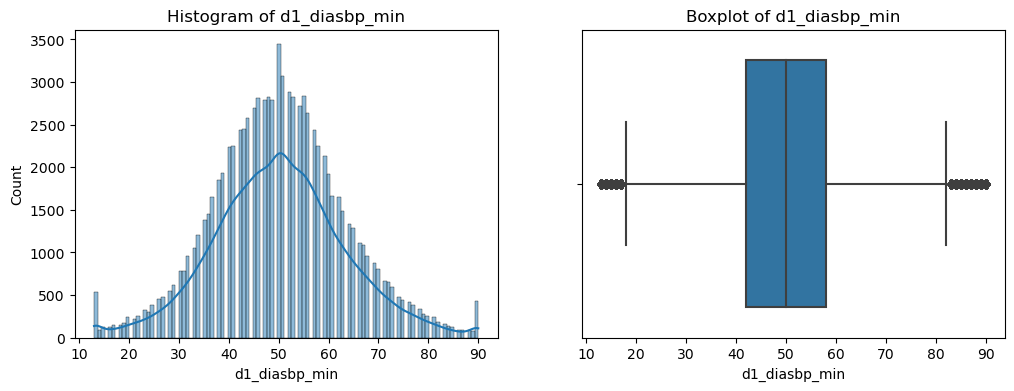

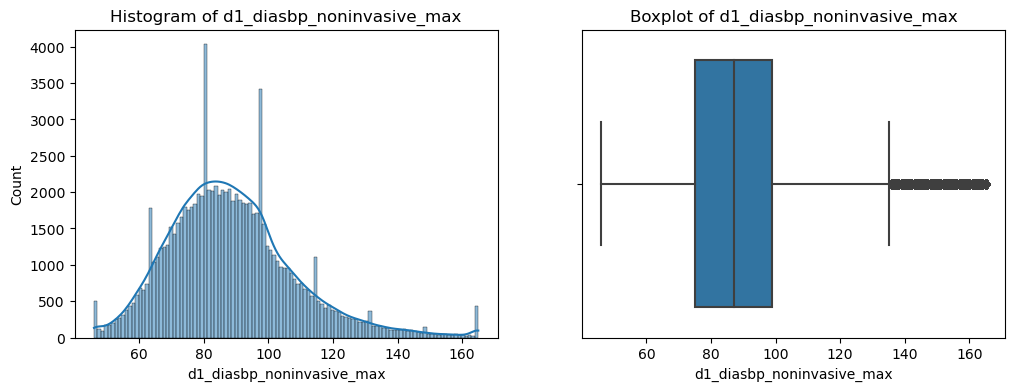

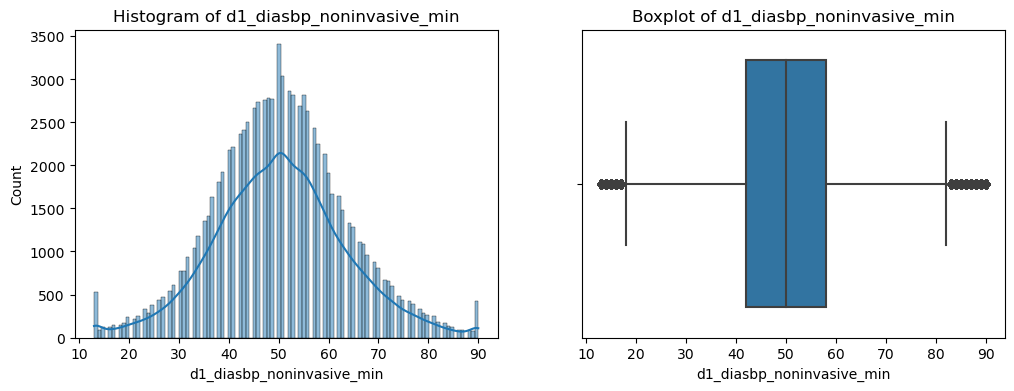

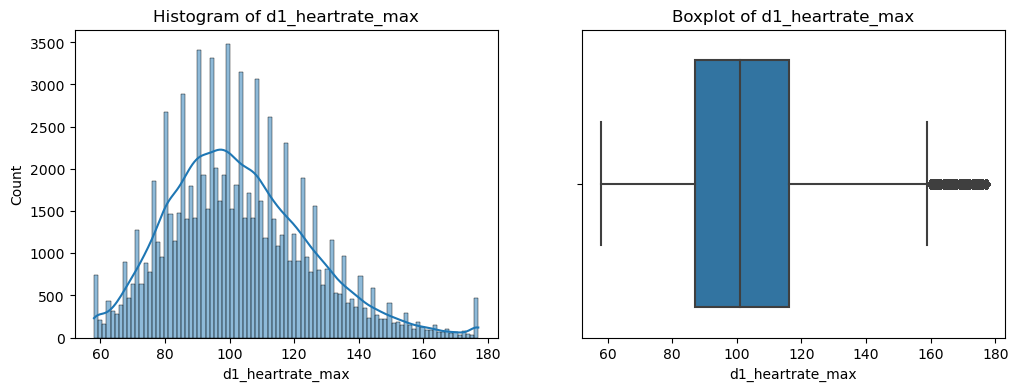

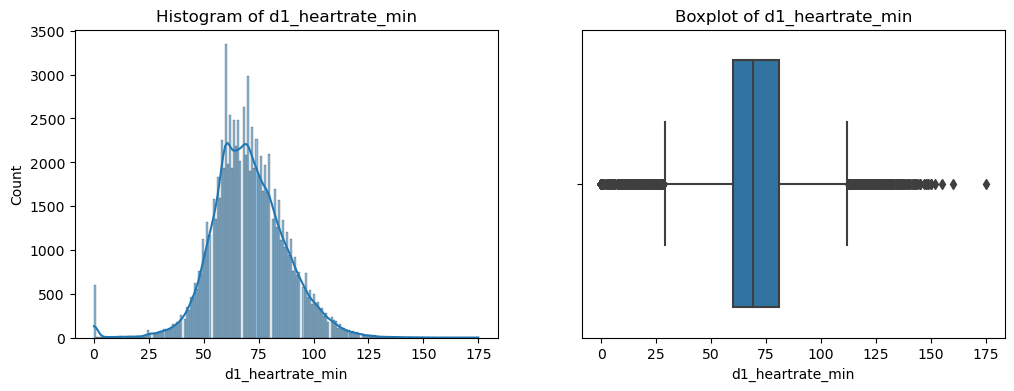

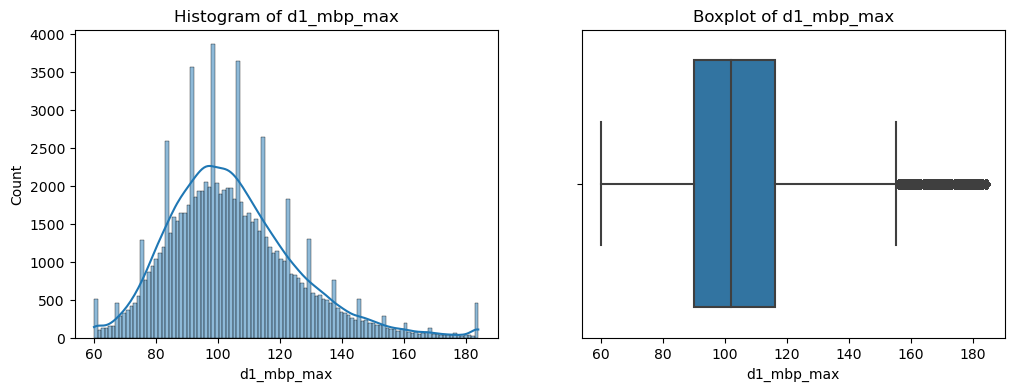

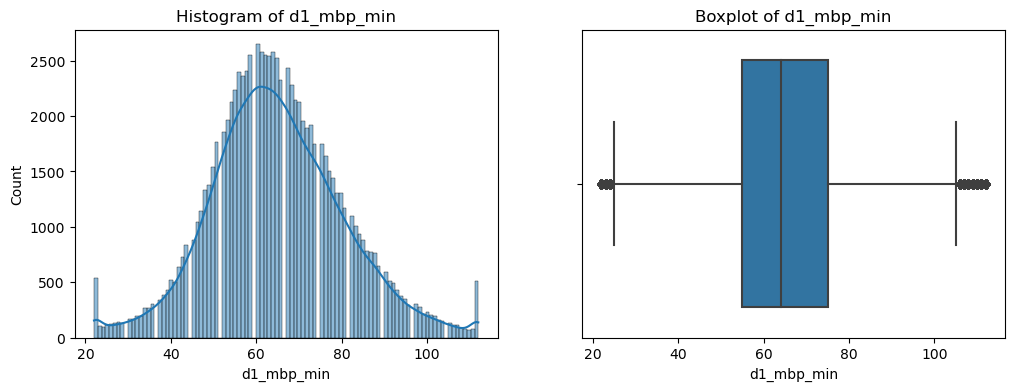

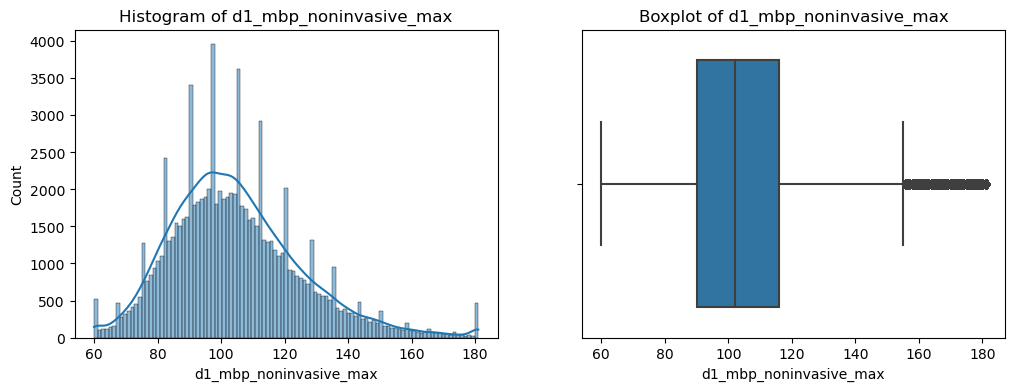

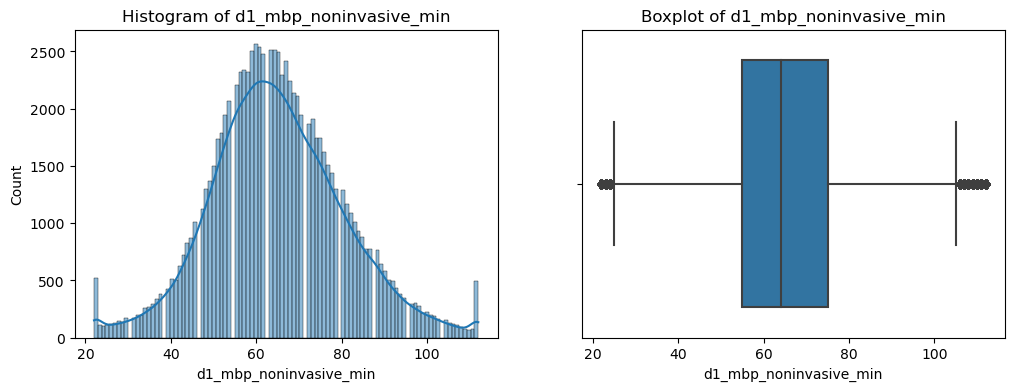

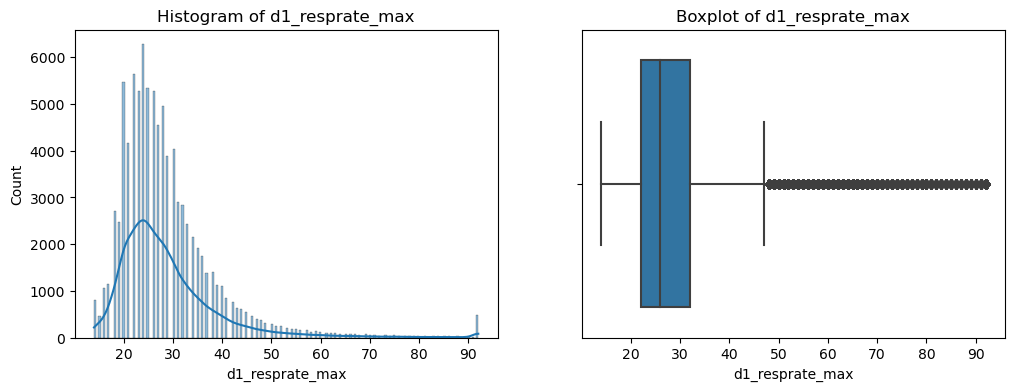

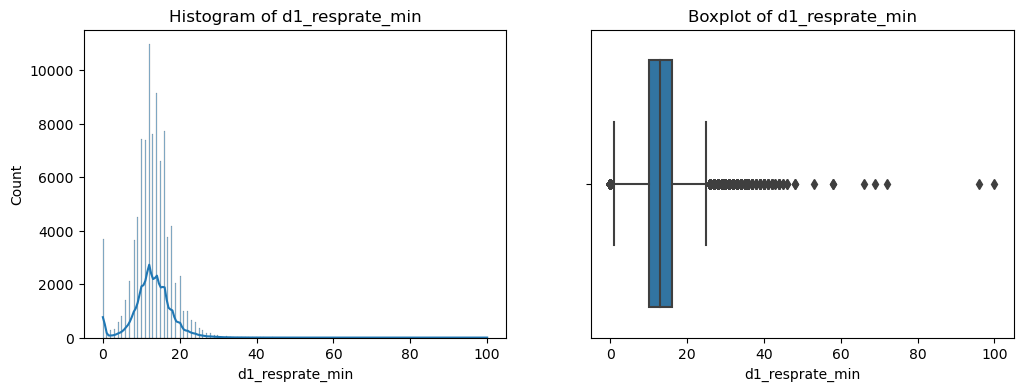

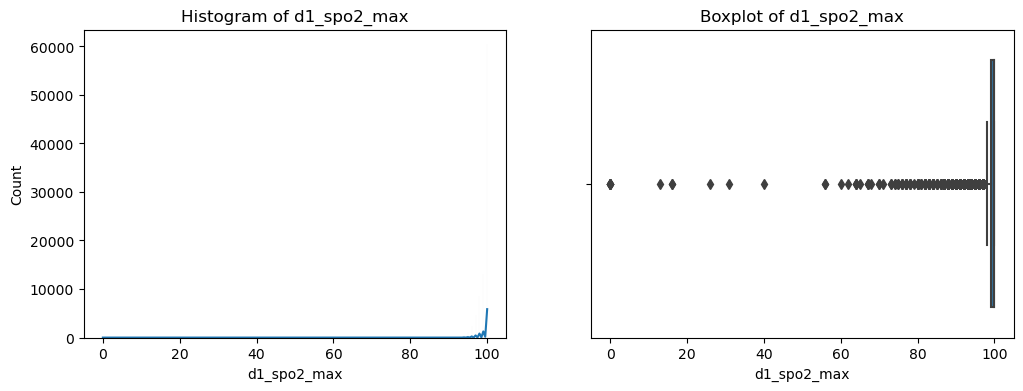

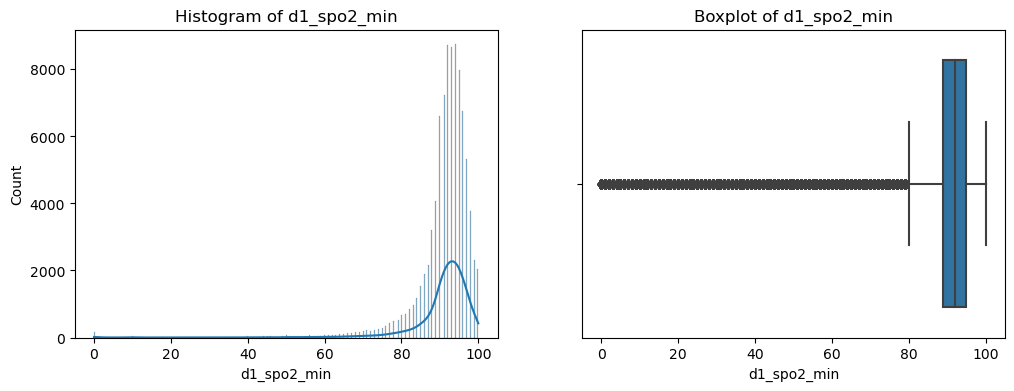

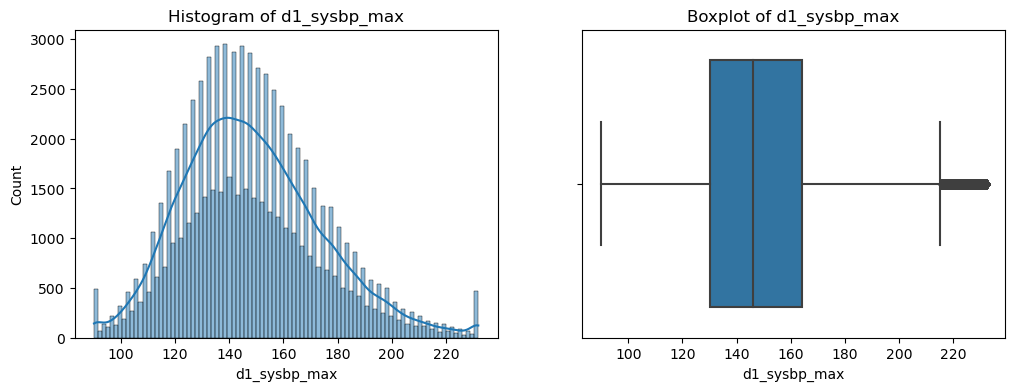

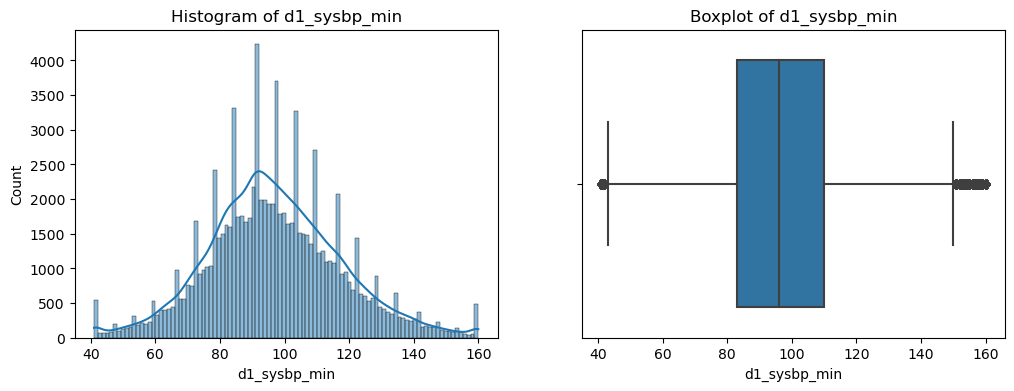

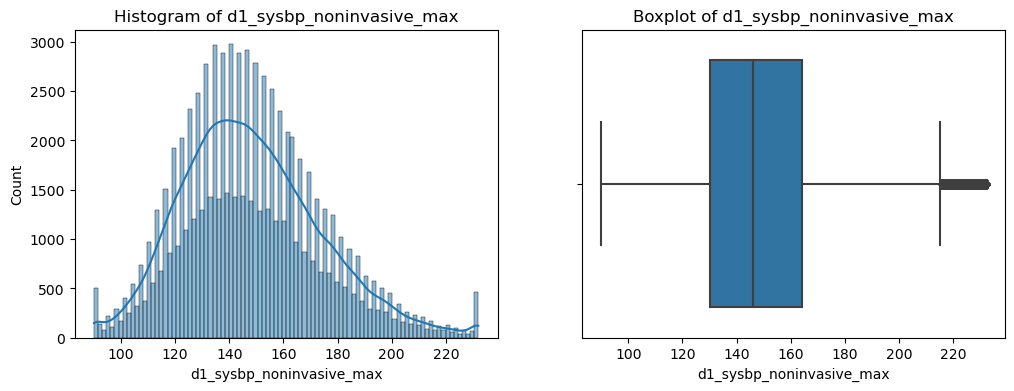

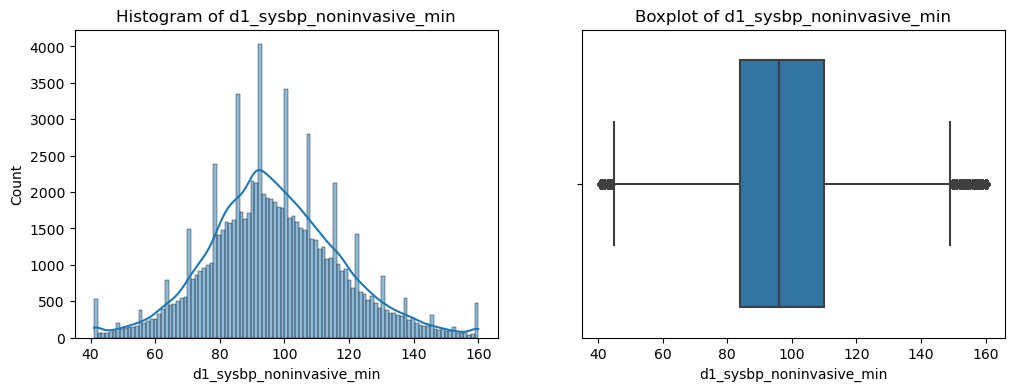

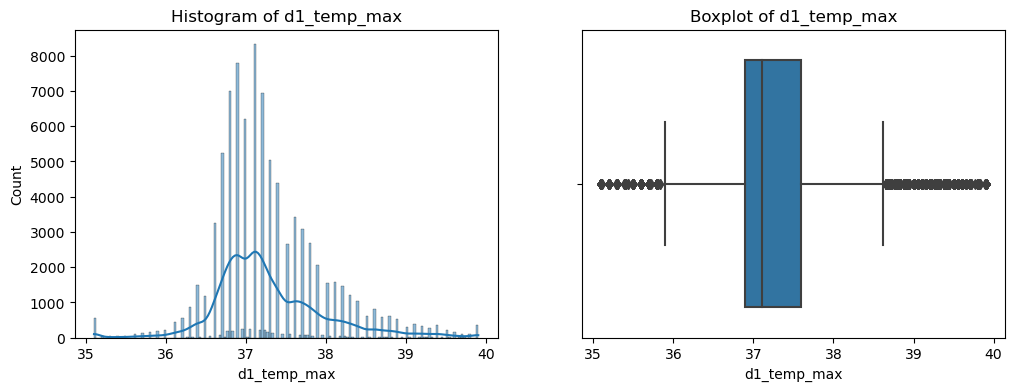

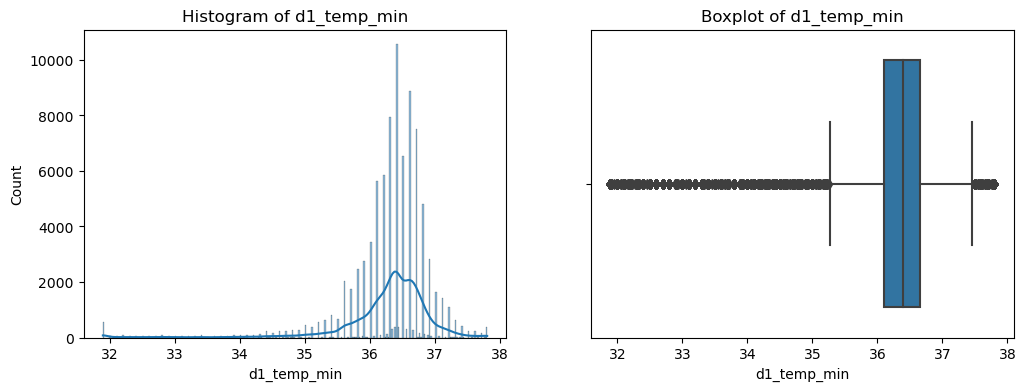

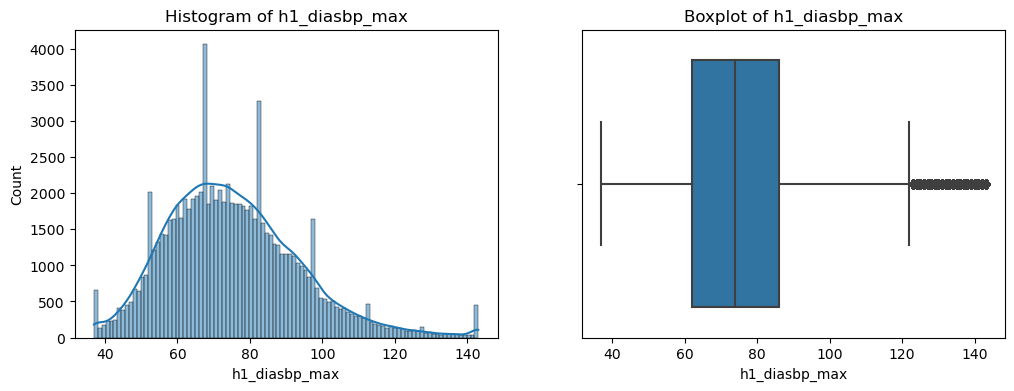

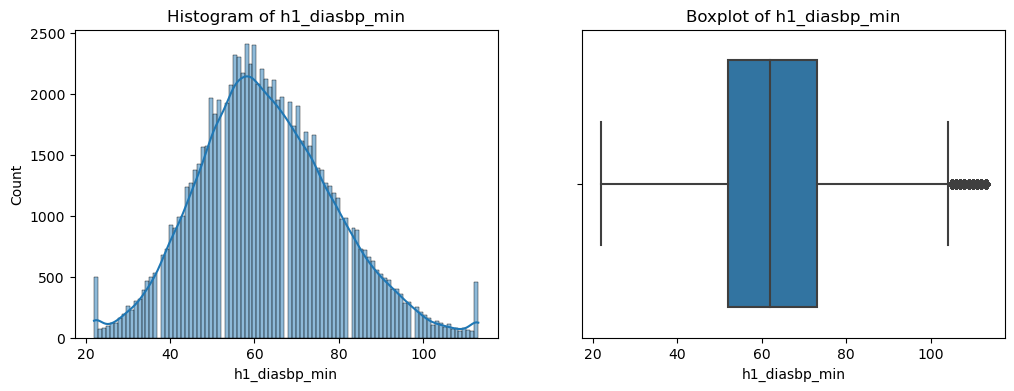

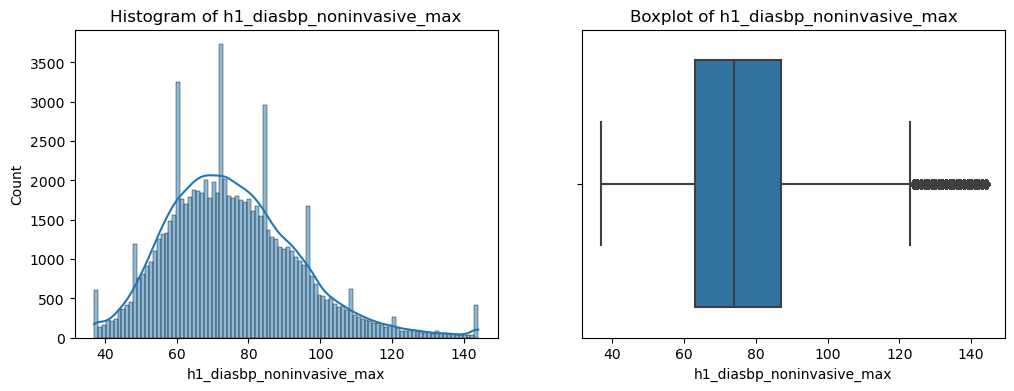

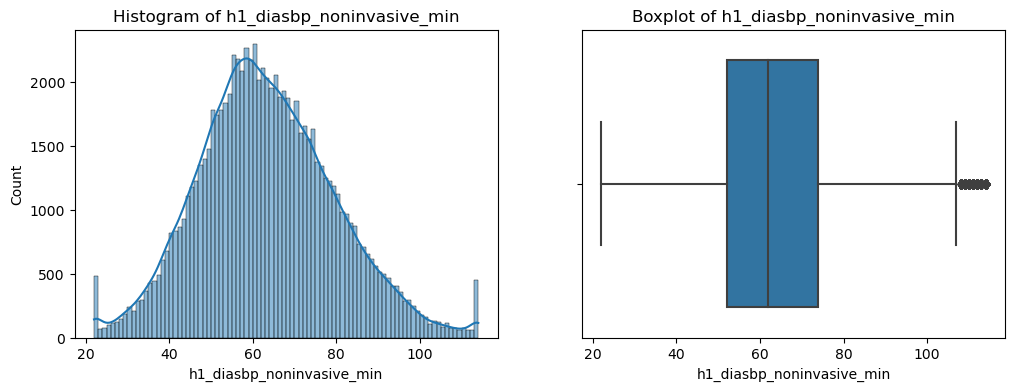

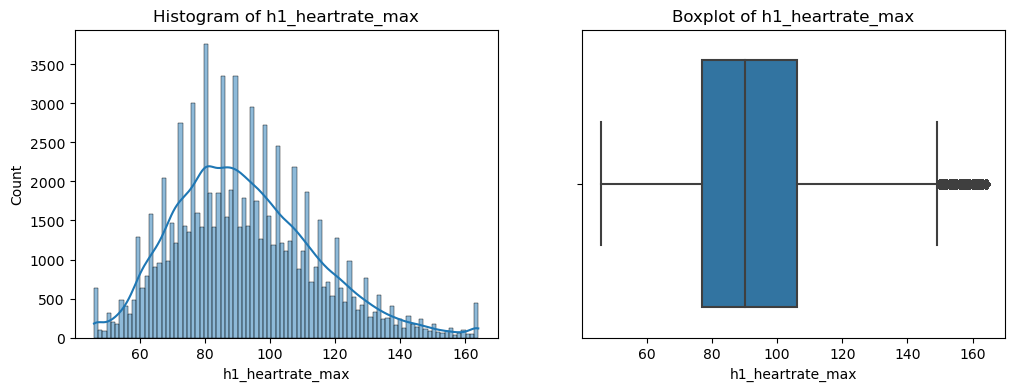

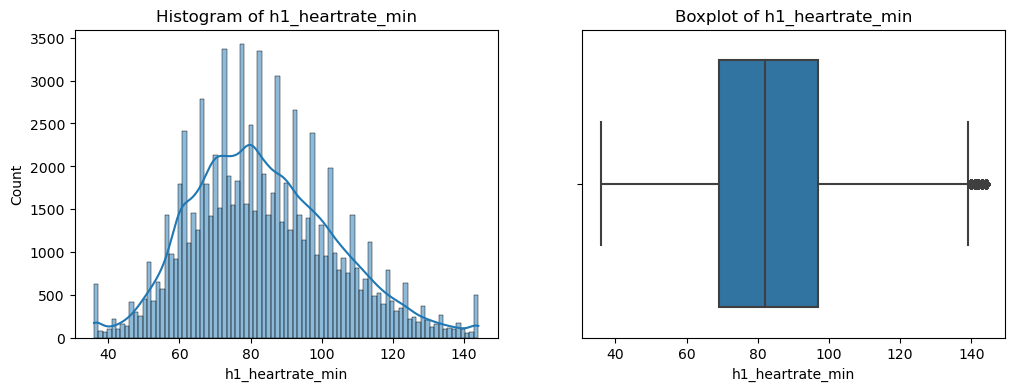

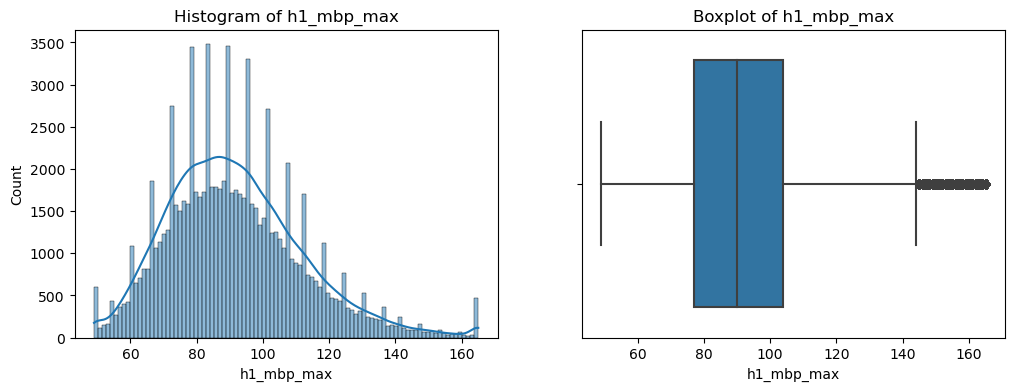

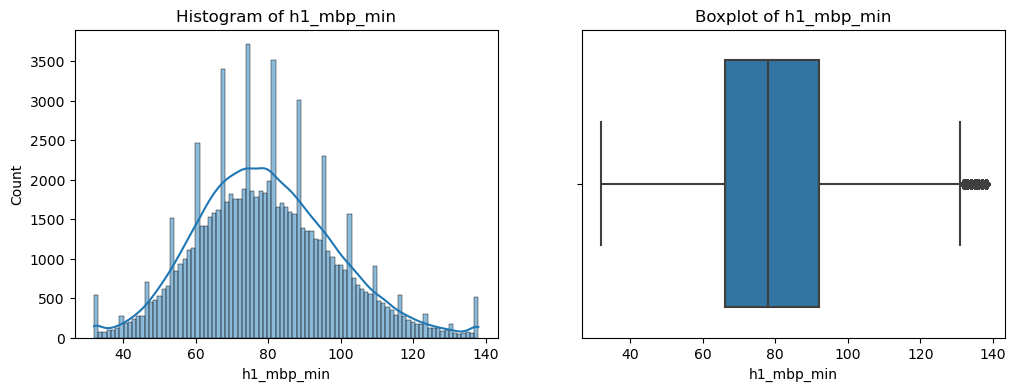

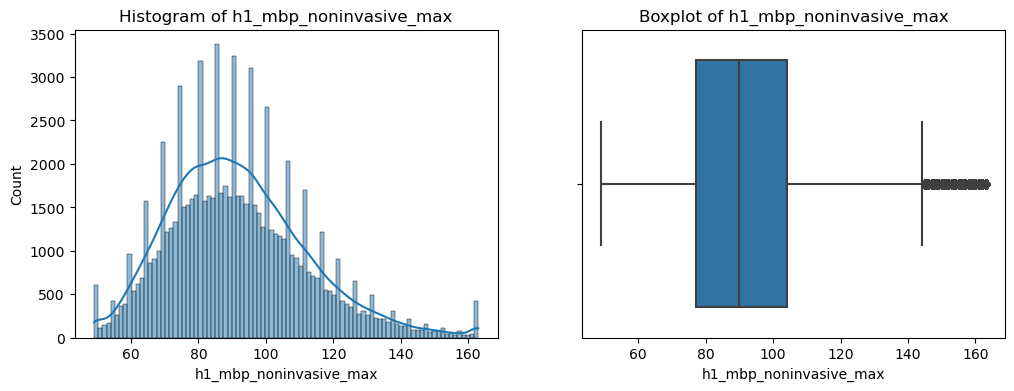

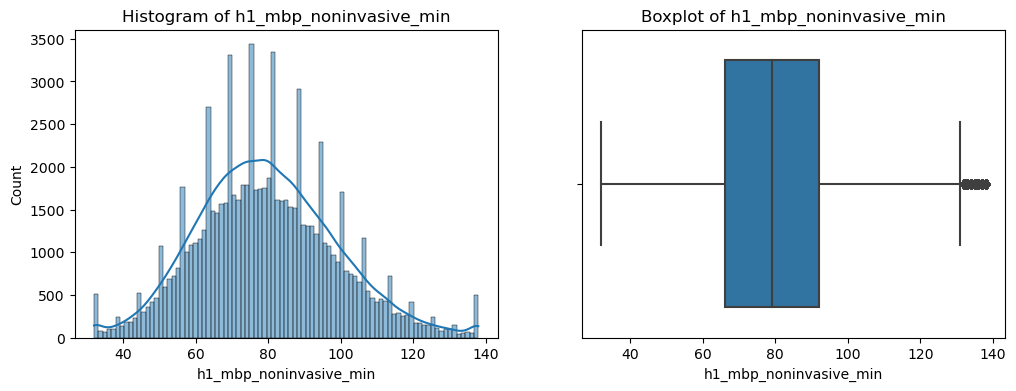

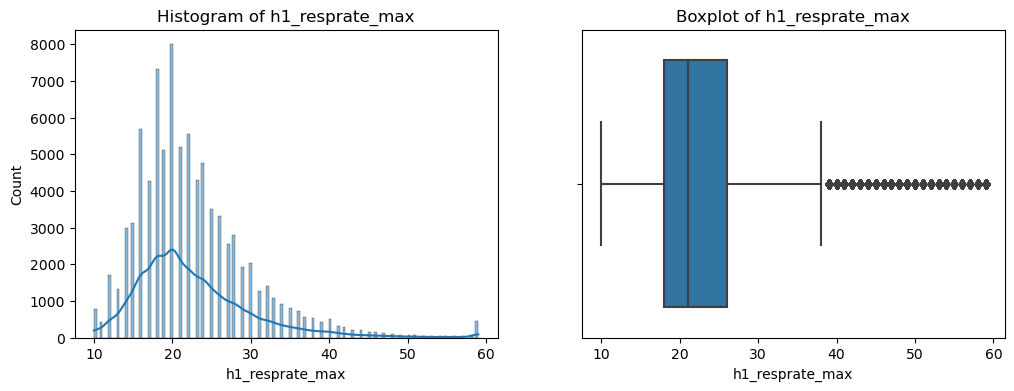

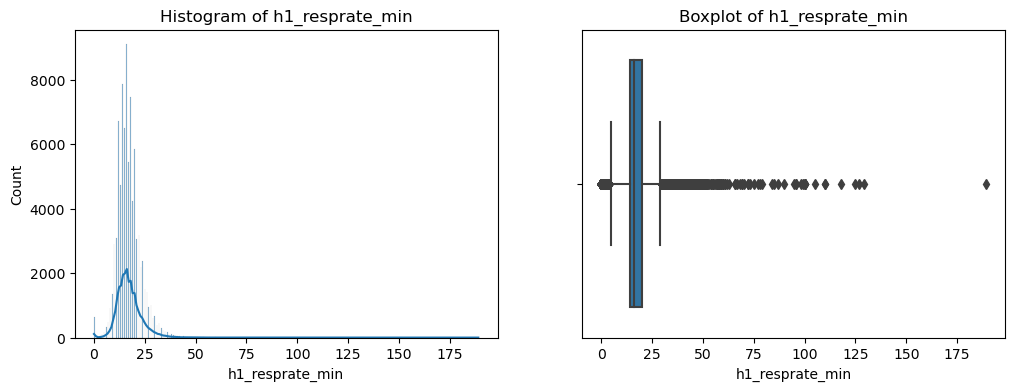

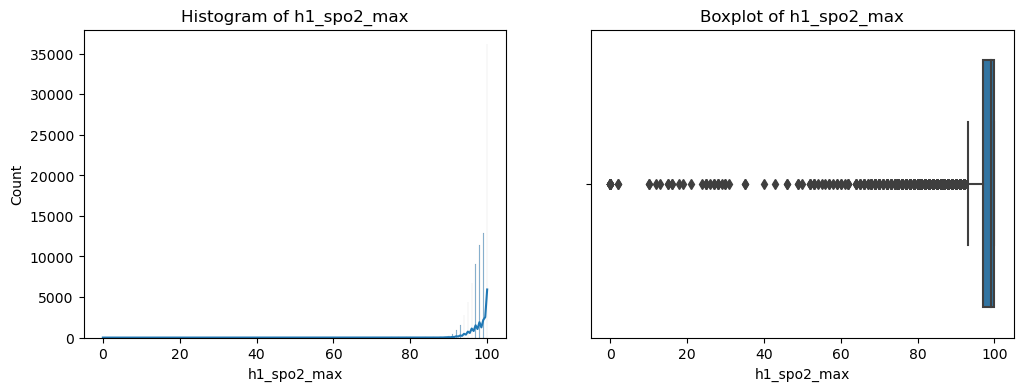

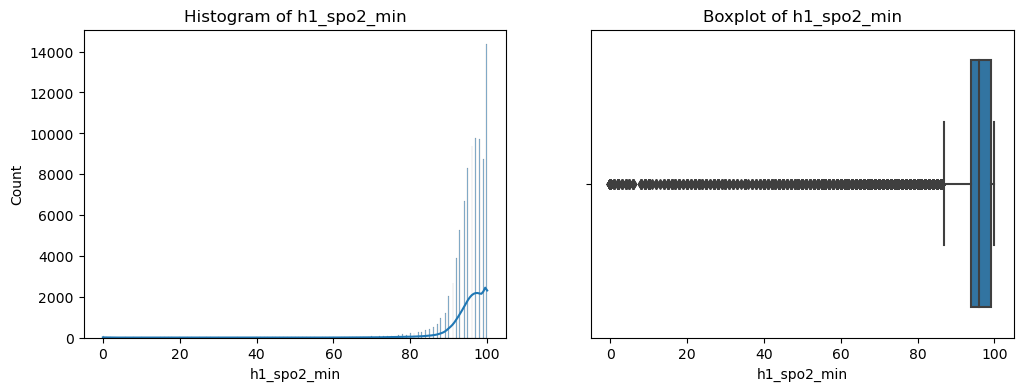

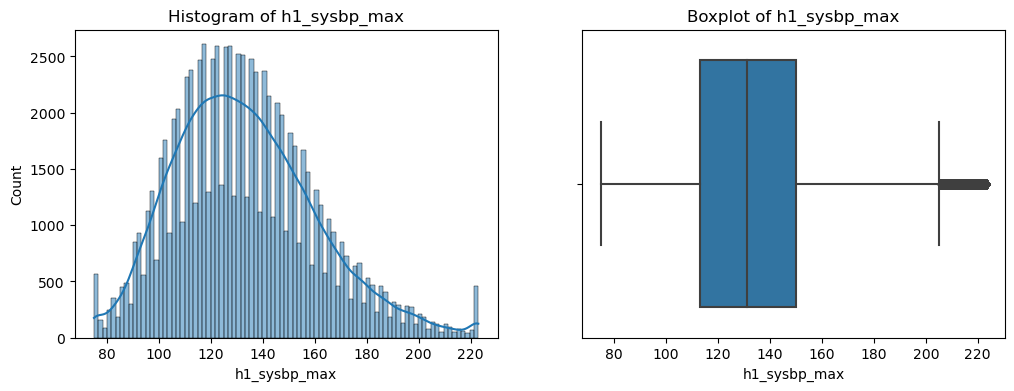

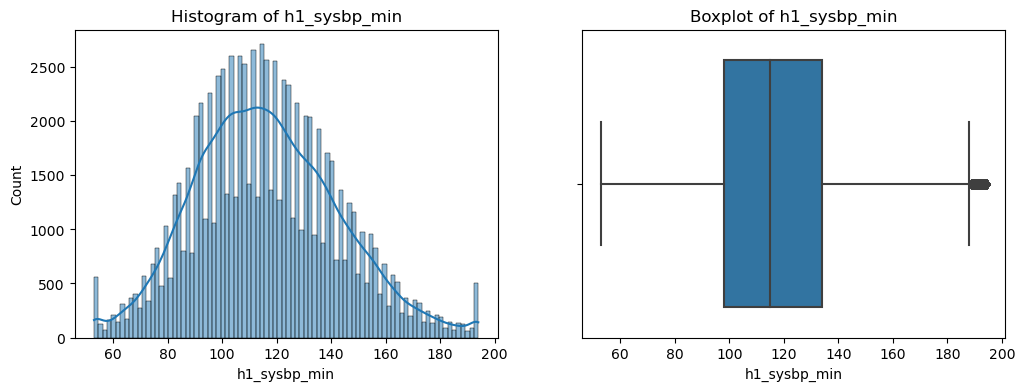

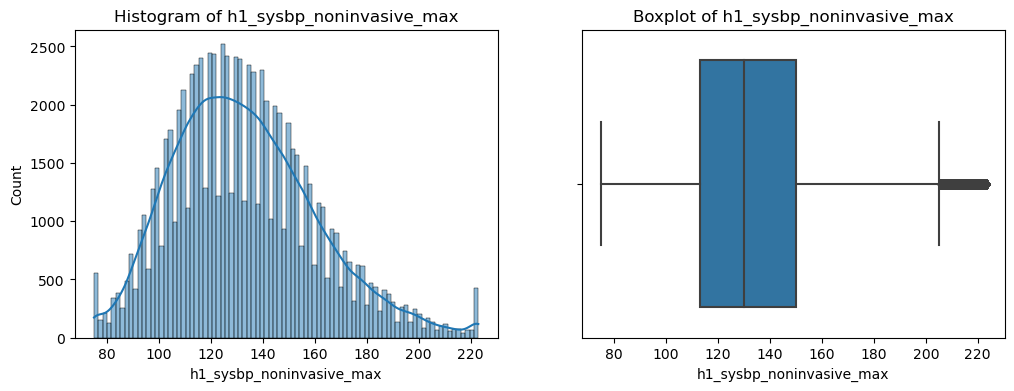

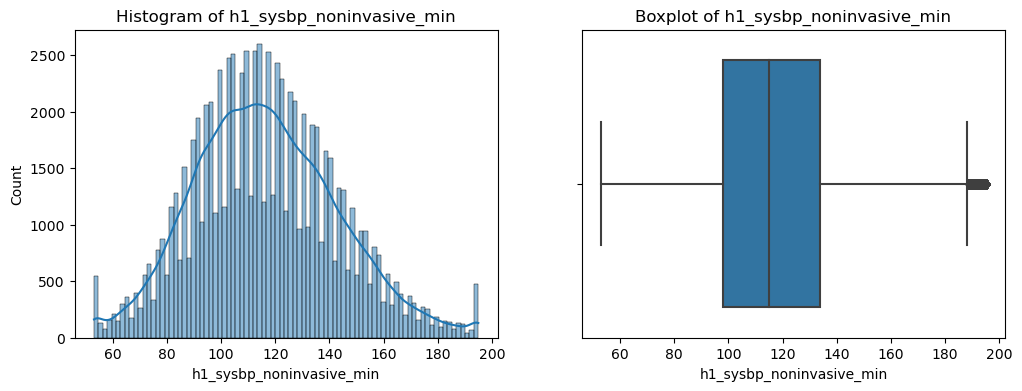

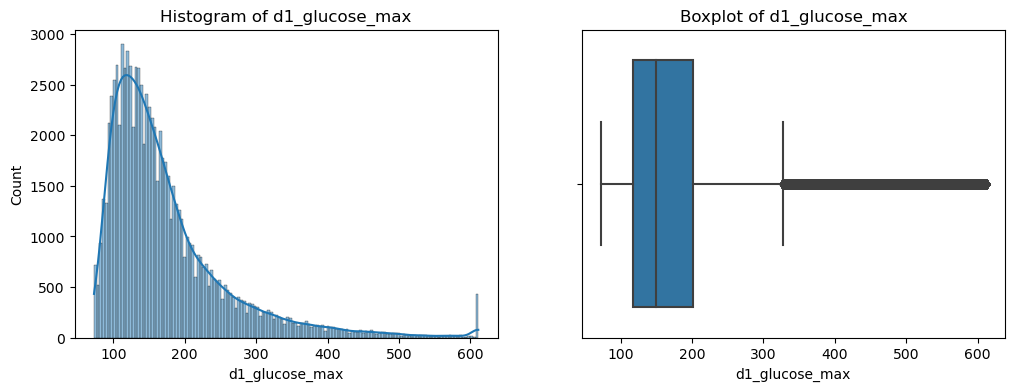

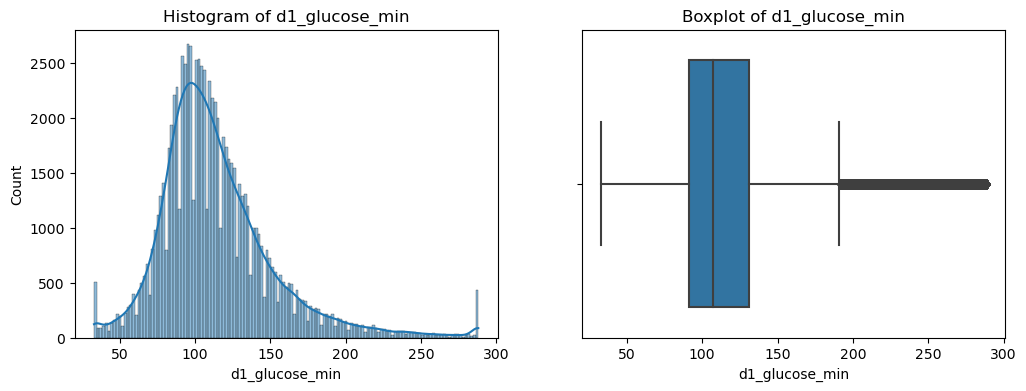

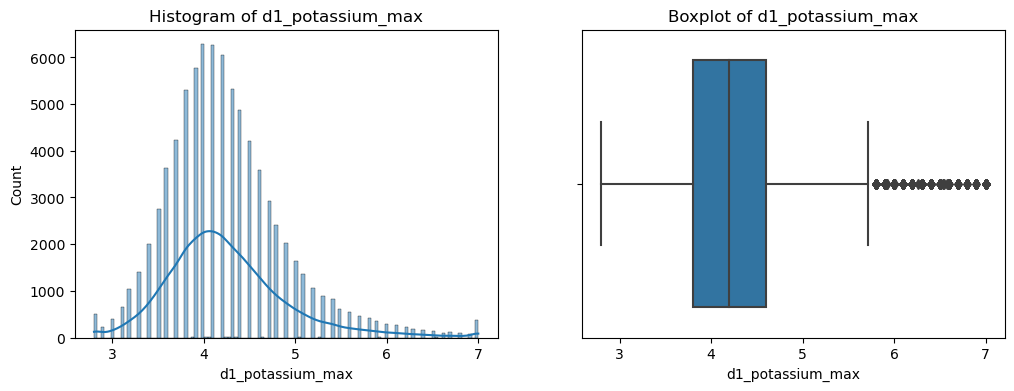

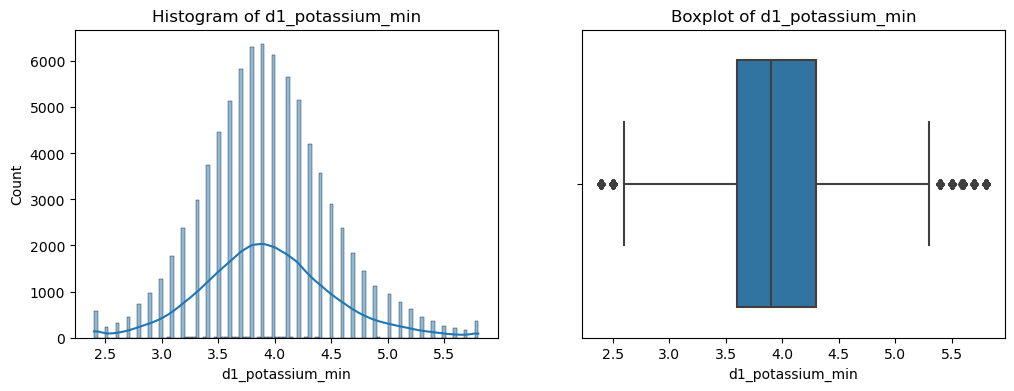

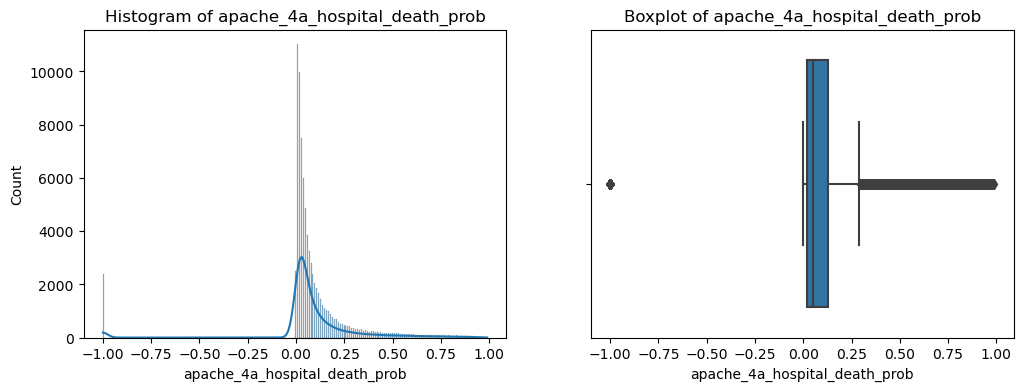

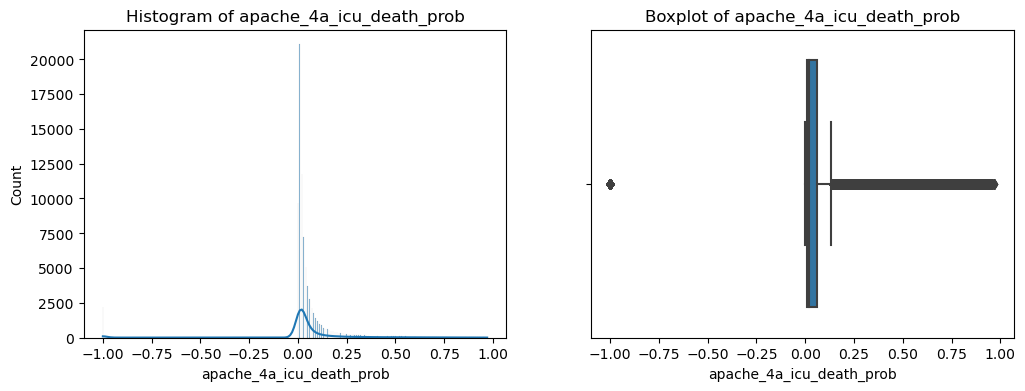

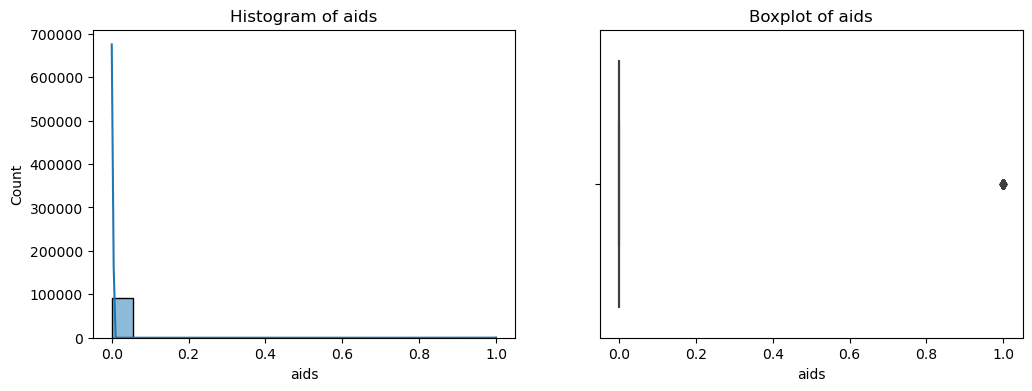

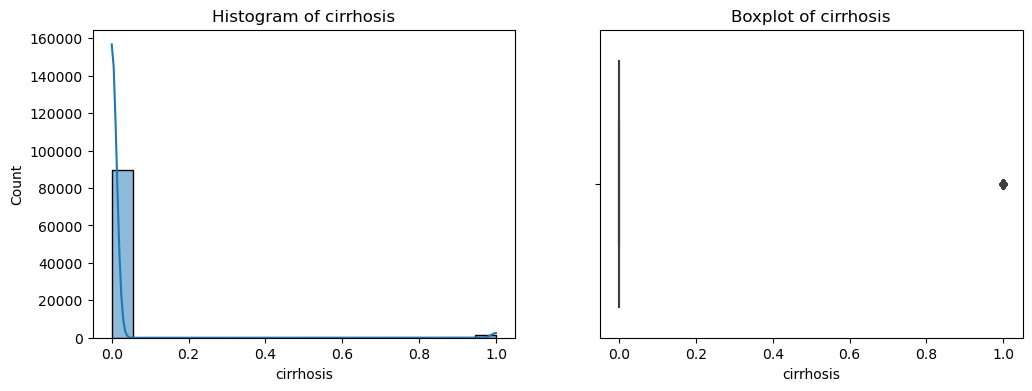

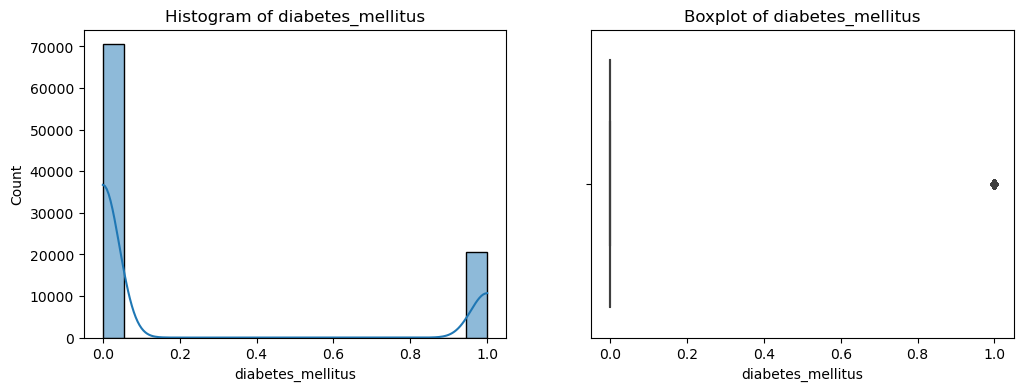

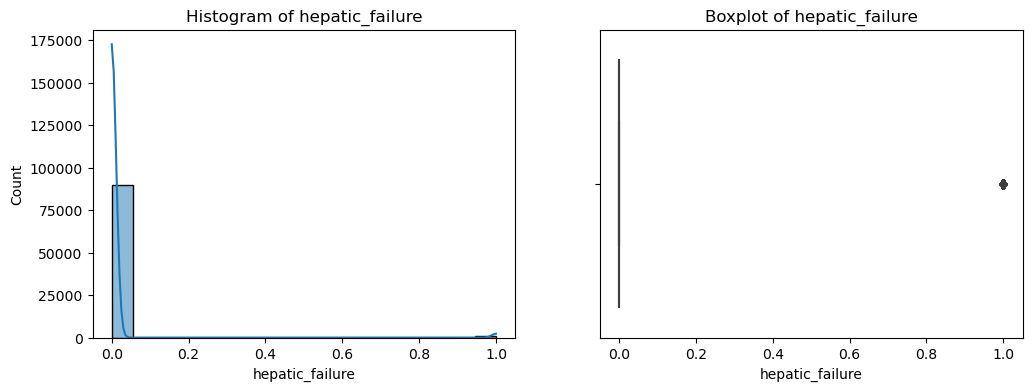

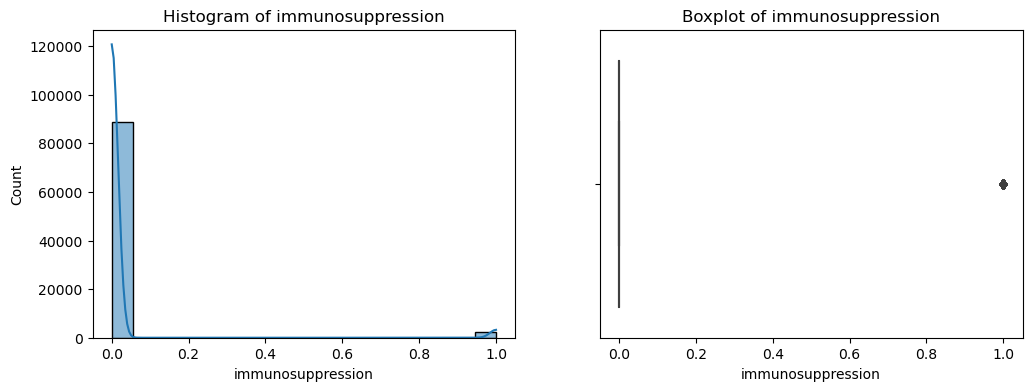

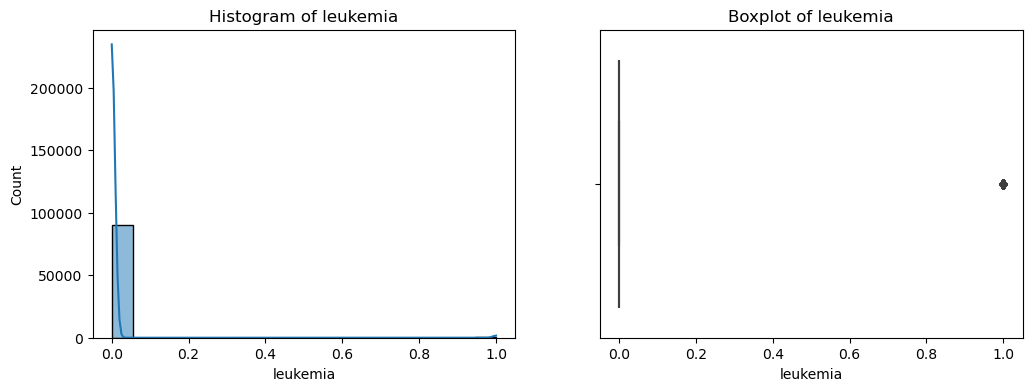

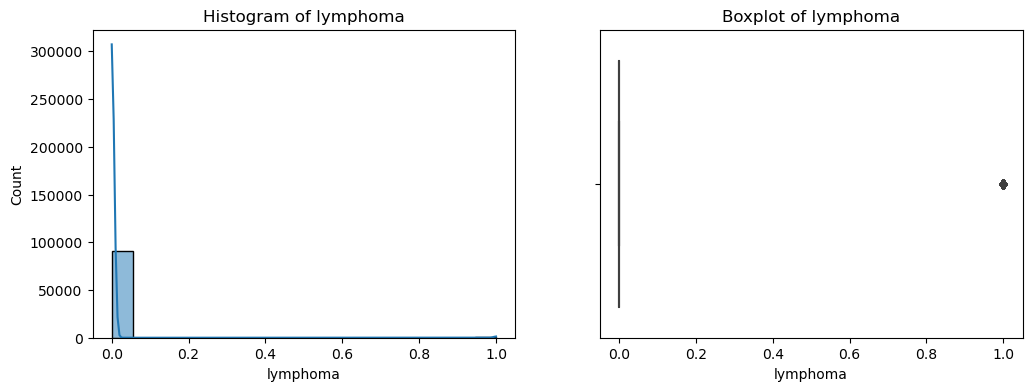

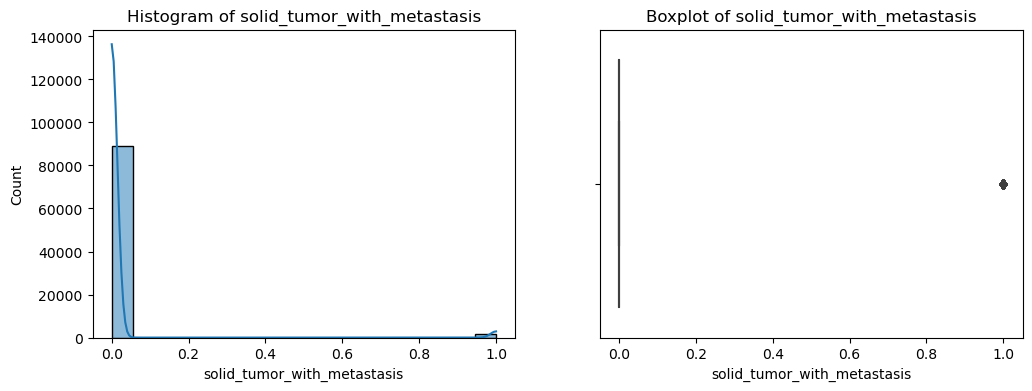

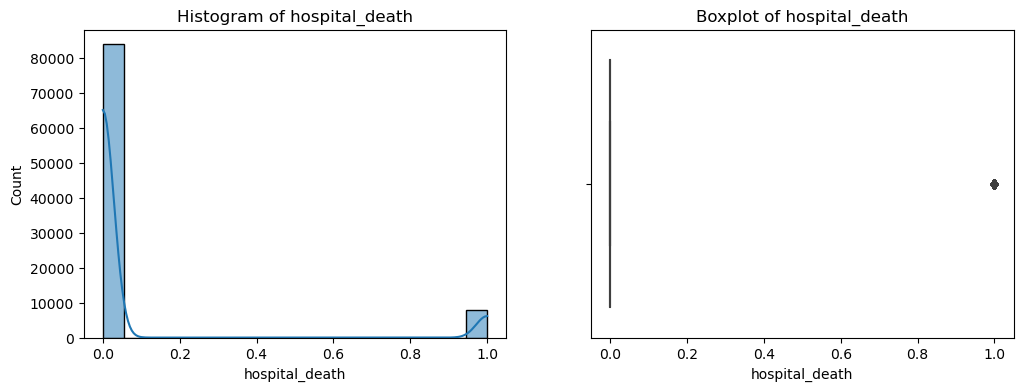

In [94]:
# Analyze numerical features
# Histograms and boxplots
for col in numerical_features:
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data[col].dropna(), kde=True)
    plt.title(f'Histogram of {col}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    
    plt.show()


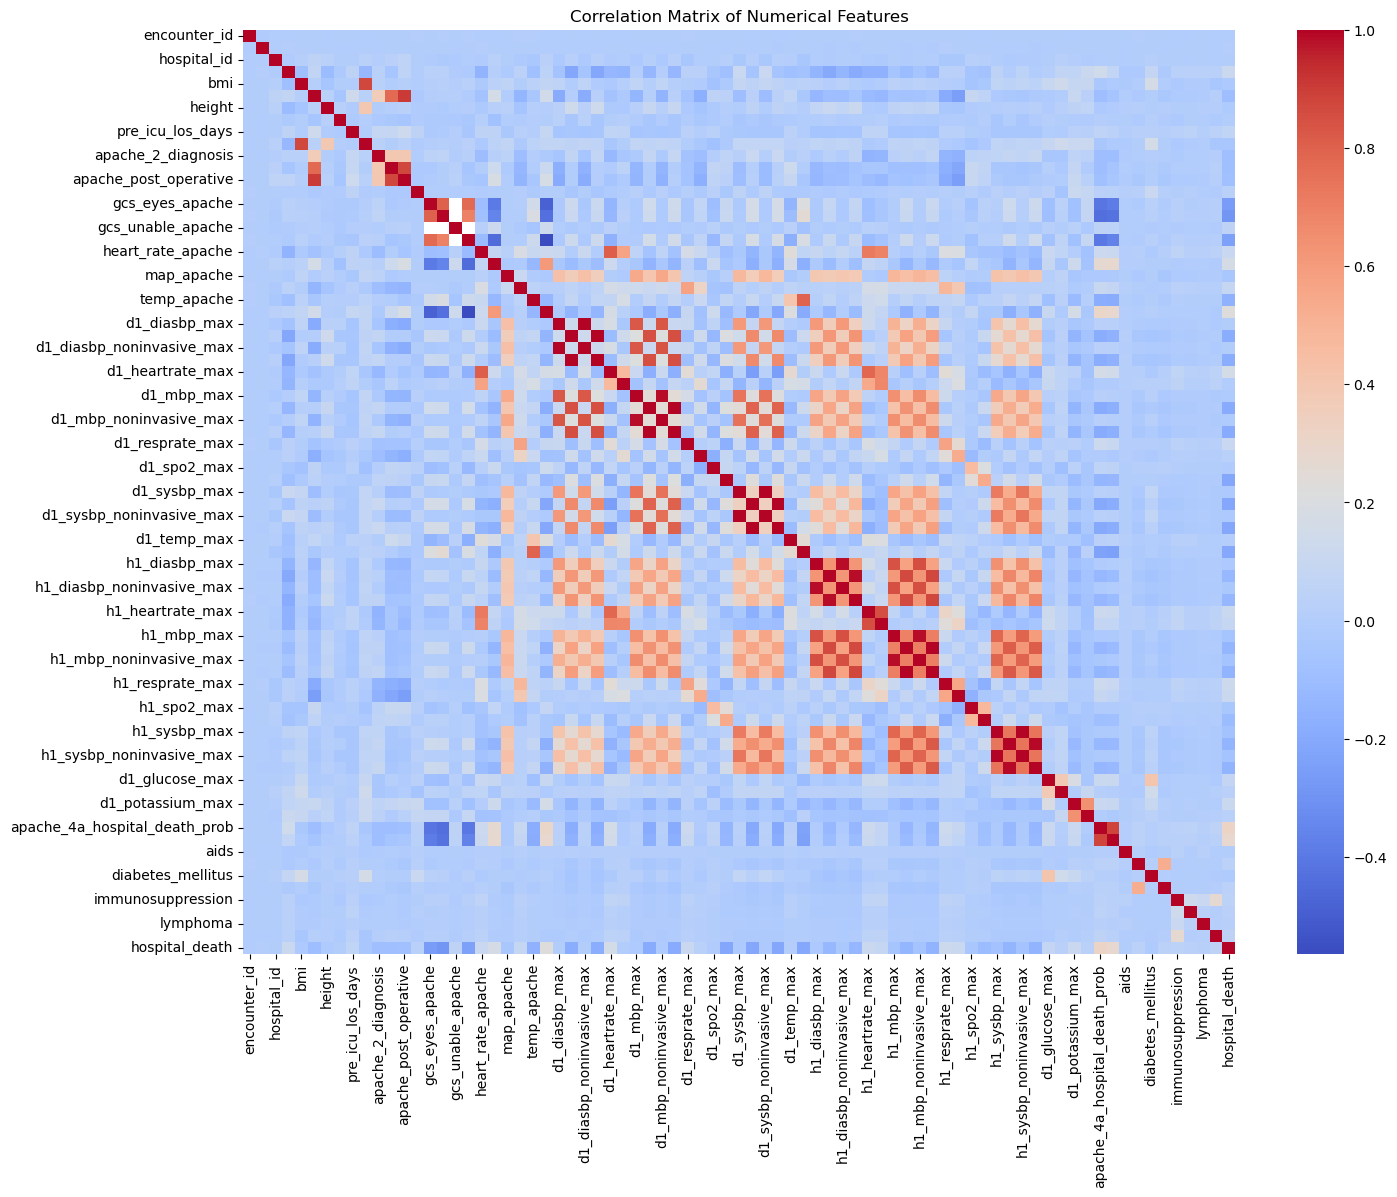


Features Correlated with Hospital Death:
hospital_death                   1.000000
apache_4a_hospital_death_prob    0.311043
apache_4a_icu_death_prob         0.283913
ventilated_apache                0.228661
intubated_apache                 0.173139
                                   ...   
d1_spo2_min                     -0.210100
d1_sysbp_min                    -0.210170
gcs_verbal_apache               -0.241044
gcs_eyes_apache                 -0.260373
gcs_motor_apache                -0.282449
Name: hospital_death, Length: 77, dtype: float64


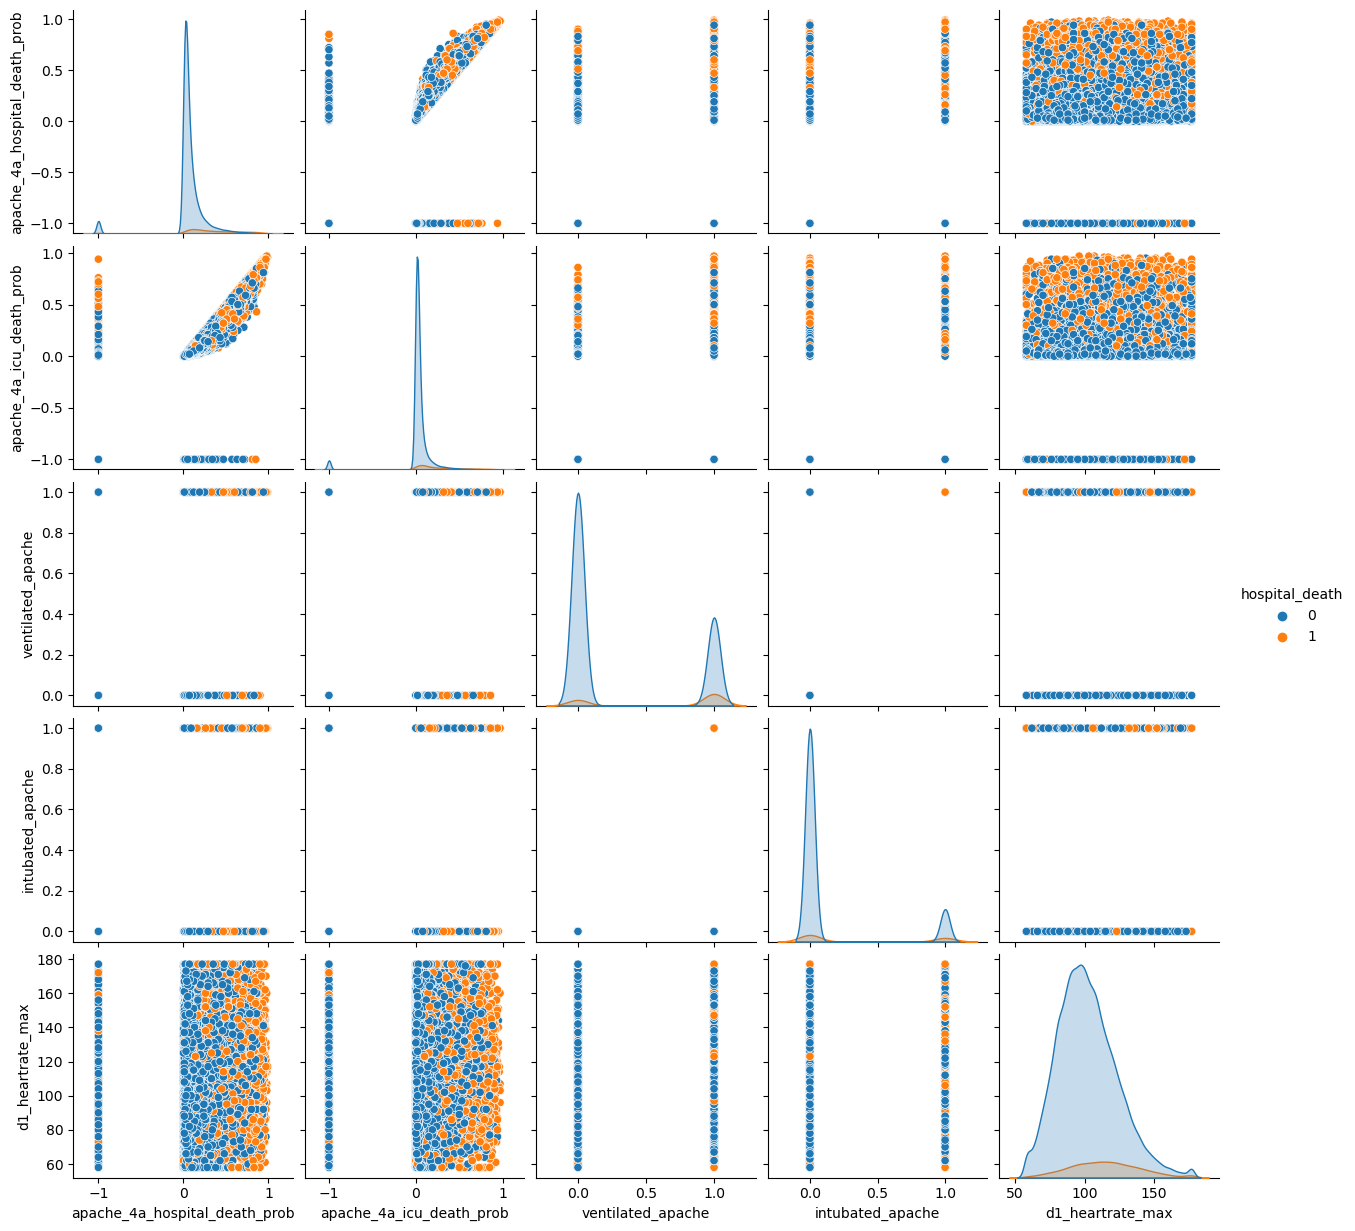


Highly Correlated Feature Pairs (Correlation > 0.8):
weight and bmi: Correlation = 0.8773391271116863
apache_post_operative and elective_surgery: Correlation = 0.9082467762773618
apache_post_operative and apache_3j_diagnosis: Correlation = 0.8756550560507167
gcs_motor_apache and gcs_eyes_apache: Correlation = 0.8001269605326863
d1_diasbp_noninvasive_max and d1_diasbp_max: Correlation = 0.997831233959615
d1_diasbp_noninvasive_min and d1_diasbp_min: Correlation = 0.9968714632429122
d1_heartrate_max and heart_rate_apache: Correlation = 0.8047570154864002
d1_mbp_max and d1_diasbp_max: Correlation = 0.8230611193862741
d1_mbp_max and d1_diasbp_noninvasive_max: Correlation = 0.8261028422080462
d1_mbp_min and d1_diasbp_min: Correlation = 0.8532835036701957
d1_mbp_min and d1_diasbp_noninvasive_min: Correlation = 0.8524544296172973
d1_mbp_noninvasive_max and d1_diasbp_max: Correlation = 0.8332513592173377
d1_mbp_noninvasive_max and d1_diasbp_noninvasive_max: Correlation = 0.8355252702331383
d1_

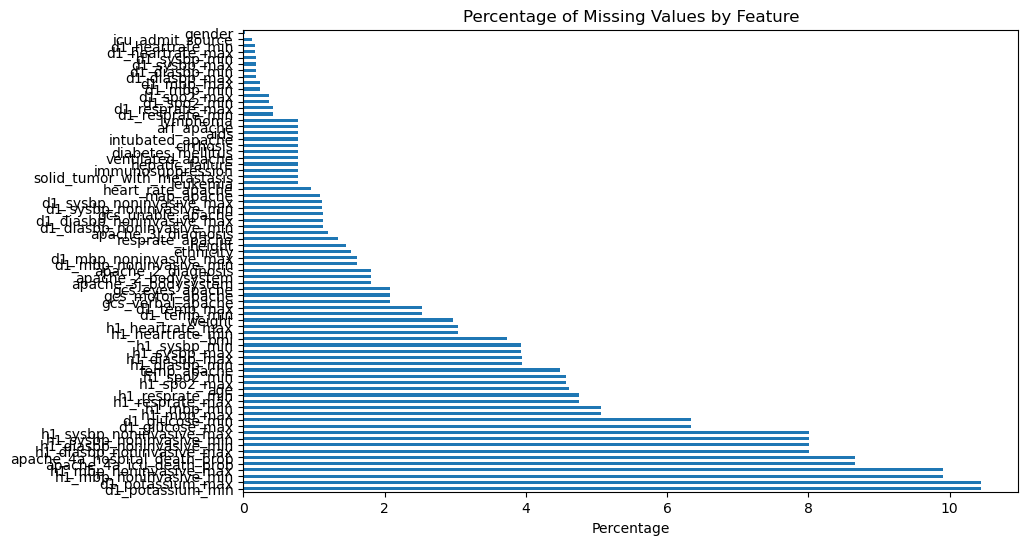

In [95]:
# Correlation matrix
plt.figure(figsize=(16, 12))
corr_matrix = data[numerical_features].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Identify features highly correlated with the target variable
correlations_with_target = corr_matrix['hospital_death'].sort_values(ascending=False)
print("\nFeatures Correlated with Hospital Death:")
print(correlations_with_target)

# Pair plots for top correlated features
top_corr_features = correlations_with_target.index[1:6]  # Exclude 'hospital_death' itself
sns.pairplot(data, vars=top_corr_features, hue='hospital_death')
plt.show()

# Check for multicollinearity (features highly correlated with each other)
# Find pairs with correlation above a threshold (e.g., 0.8)
threshold = 0.8
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            col_pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
            high_corr_pairs.append(col_pair)

print("\nHighly Correlated Feature Pairs (Correlation > 0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: Correlation = {pair[2]}")

# Analyze missing values in more detail
# Percentage of missing values
missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
print("\nPercentage of Missing Values in Columns:")
print(missing_percentage)

# Visualize missing data percentages
plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='barh')
plt.title('Percentage of Missing Values by Feature')
plt.xlabel('Percentage')
plt.show()


### Data Cleaning

In [96]:

# Columns to drop
cols_to_drop = ['encounter_id', 'patient_id', 'hospital_id', 'icu_id']
apache_cols = ['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']

# Save the values of the 'apache' columns before dropping
apache_values = data[apache_cols].copy()

# Combine both lists of columns to drop
cols_to_drop.extend(apache_cols)  # Adds apache columns to the list of columns to drop

# Drop the combined list of columns
data.drop(columns=cols_to_drop, inplace=True)

# Print confirmation of columns dropped
print(f"Dropped columns: {cols_to_drop}")

# Display saved values of the apache columns
print("Saved values of apache columns:")
print(apache_values.head())


categorical_features = data.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical Features:", categorical_features)

# Impute missing values in categorical features with 'Unknown'
for col in categorical_features:
    data[col] = data[col].fillna('MISSING')

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)
print("Applied one-hot encoding to categorical variables.")

# Update list of numerical features after encoding
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('hospital_death')  # Exclude the target variable

from sklearn.impute import SimpleImputer

# Create an imputer object with median strategy
median_imputer = SimpleImputer(strategy='median')

# Apply the imputer to numerical columns
data[numerical_features] = median_imputer.fit_transform(data[numerical_features])

print("Imputed missing values in numerical features with median values.")




Dropped columns: ['encounter_id', 'patient_id', 'hospital_id', 'icu_id', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']
Saved values of apache columns:
   apache_4a_hospital_death_prob  apache_4a_icu_death_prob
0                           0.10                      0.05
1                           0.47                      0.29
2                           0.00                      0.00
3                           0.04                      0.03
4                            NaN                       NaN

Categorical Features: ['ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem']
Applied one-hot encoding to categorical variables.
Imputed missing values in numerical features with median values.


In [97]:
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
threshold = 0.8
high_corr_features = [column for column in upper.columns if any(upper[column] > threshold)]

print("Highly correlated features (correlation > 0.8):", high_corr_features)

# I don't think we want to drop correlated features 

Highly correlated features (correlation > 0.8): ['weight', 'apache_post_operative', 'gcs_motor_apache', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 'icu_admit_source_Operating Room / Recovery', 'apache_2_bodysystem_Gastrointestinal', 'apache_2_bodysystem_Haematologic', 'apache_2_bodysystem_MISSING', 'apache_2_bodysystem_Metabolic', 'apache_2_bodysystem_Neurologic', 'apache_2_bodysystem_Renal/Genitourinary', 'apache_2_bodysystem_Respiratory', 'apache_2_bodysystem_Trauma']


In [98]:
# what to do with missing values
# keep correlated varibales? 
# i need to scale for almost anything not tree?
# use PCA to only choose a subset of the blood pressure features 

In [99]:
# Checking if any rows have different values between invasive and noninvasive mean blood pressure measurements

# Create a boolean mask to identify rows where the values differ
mbp_difference_mask = (
    (data['d1_mbp_max'] != data['d1_mbp_noninvasive_max']) |
    (data['d1_mbp_min'] != data['d1_mbp_noninvasive_min'])
)

# Filter rows where the difference exists
mbp_differences = data[mbp_difference_mask]

# Display the rows with differences
print("Rows where 'd1_mbp_max' and 'd1_mbp_min' differ from 'd1_mbp_noninvasive_max' and 'd1_mbp_noninvasive_min':")
display(mbp_differences)

Rows where 'd1_mbp_max' and 'd1_mbp_min' differ from 'd1_mbp_noninvasive_max' and 'd1_mbp_noninvasive_min':


age        bmi  elective_surgery  height  pre_icu_los_days  weight  \
19     39.0  37.010278               1.0  177.80          5.163889  117.00   
46     64.0  16.980389               0.0  180.30          2.817361   55.20   
52     73.0  28.058219               1.0  177.80          0.000000   88.70   
63     73.0  20.351971               1.0  167.50          0.004861   57.10   
65     41.0  37.166569               1.0  167.60          3.390278  104.40   
...     ...        ...               ...     ...               ...     ...   
91606  75.0  24.058304               0.0  147.30          0.033333   52.20   
91610  65.0  21.824019               0.0  162.60          0.022917   57.70   
91611  74.0  32.622159               0.0  170.20          3.293750   94.50   
91625  65.0  21.947625               0.0  157.48         -0.868750   54.43   
91689  65.0  24.445450               0.0  188.00         -1.735417   86.40   

       apache_2_diagnosis  apache_3j_diagnosis  apache_post_operative  \
19                  203.0              1206.03                    1.0   
46                  217.0              1502.02                    1.0   
52                  202.0              1204.02                    1.0   
63                  203.0              1206.03                    1.0   
65                  308.0              1207.01                    1.0   
...                   ...                  ...                    ...   
91606               301.0               403.01                    0.0   
91610               117.0               106.01                    0.0   
91611               114.0               102.01                    0.0   
91625               122.0               409.02                    0.0   
91689               122.0               409.02                    0.0   

       arf_apache  ...  apache_2_bodysystem_Gastrointestinal  \
19            0.0  ...                                   0.0   
46            0.0  ...                                   0.0   
52            0.0  ...                                   0.0   
63            0.0  ...                                   0.0   
65            0.0  ...                                   0.0   
...           ...  ...                                   ...   
91606         0.0  ...                                   0.0   
91610         0.0  ...                                   0.0   
91611         1.0  ...                                   0.0   
91625         0.0  ...                                   0.0   
91689         0.0  ...                                   0.0   

       apache_2_bodysystem_Haematologic  apache_2_bodysystem_MISSING  \
19                                  0.0                          0.0   
46                                  0.0                          0.0   
52                                  0.0                          0.0   
63                                  0.0                          0.0   
65                                  0.0                          0.0   
...                                 ...                          ...   
91606                               0.0                          0.0   
91610                               0.0                          0.0   
91611                               0.0                          0.0   
91625                               0.0                          1.0   
91689                               0.0                          1.0   

       apache_2_bodysystem_Metabolic  apache_2_bodysystem_Neurologic  \
19                               0.0                             0.0   
46                               0.0                             1.0   
52                               0.0                             0.0   
63                               0.0                             0.0   
65                               0.0                             0.0   
...                              ...                             ...   
91606                            0.0                    

In [100]:
for col in data.columns:
    print(col)

age
bmi
elective_surgery
height
pre_icu_los_days
weight
apache_2_diagnosis
apache_3j_diagnosis
apache_post_operative
arf_apache
gcs_eyes_apache
gcs_motor_apache
gcs_unable_apache
gcs_verbal_apache
heart_rate_apache
intubated_apache
map_apache
resprate_apache
temp_apache
ventilated_apache
d1_diasbp_max
d1_diasbp_min
d1_diasbp_noninvasive_max
d1_diasbp_noninvasive_min
d1_heartrate_max
d1_heartrate_min
d1_mbp_max
d1_mbp_min
d1_mbp_noninvasive_max
d1_mbp_noninvasive_min
d1_resprate_max
d1_resprate_min
d1_spo2_max
d1_spo2_min
d1_sysbp_max
d1_sysbp_min
d1_sysbp_noninvasive_max
d1_sysbp_noninvasive_min
d1_temp_max
d1_temp_min
h1_diasbp_max
h1_diasbp_min
h1_diasbp_noninvasive_max
h1_diasbp_noninvasive_min
h1_heartrate_max
h1_heartrate_min
h1_mbp_max
h1_mbp_min
h1_mbp_noninvasive_max
h1_mbp_noninvasive_min
h1_resprate_max
h1_resprate_min
h1_spo2_max
h1_spo2_min
h1_sysbp_max
h1_sysbp_min
h1_sysbp_noninvasive_max
h1_sysbp_noninvasive_min
d1_glucose_max
d1_glucose_min
d1_potassium_max
d1_potassium